In [ ]:
from google.colab import files
uploaded = files.upload()

Saving generated_financial_data_5500.csv to generated_financial_data_5500.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

# Load the uploaded CSV
df = pd.read_csv('generated_financial_data_5500.csv')

# Preview the data
df.head()



,company_id,group_name,account_name,date,debit_amount,credit
0,7S4LET,Operations,Rent,24-12-2023,1569.50,NaN
1,7S4LET,IT,Bank Service Charges,09-12-2023,5984.77,NaN
2,7S4LET,IT,Miscellaneous Expense,02-06-2023,5104.40,NaN
3,7S4LET,HR,Bank Service Charges,16-07-2023,6240.26,NaN
4,7S4LET,HR,Miscellaneous Expense,08-09-2023,5216.95,NaN


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Load the CSV
df = pd.read_csv('generated_financial_data_5500.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Ensure numeric values and fill NaNs
df['debit_amount'] = pd.to_numeric(df['debit_amount'], errors='coerce').fillna(0)
df['credit'] = pd.to_numeric(df['credit'], errors='coerce').fillna(0)

# Subtract credit from debit to get actual spending
df['net_expense'] = df['debit_amount'] - df['credit']

# Set the date as the index
df.set_index('date', inplace=True)

# Resample to monthly sums
monthly_expense = df['net_expense'].resample('M').sum()

# Train-test split (e.g., 80% train, 20% test)
split_index = int(len(monthly_expense) * 0.8)
train_data = monthly_expense[:split_index].asfreq('ME').fillna(0)
test_data = monthly_expense[split_index:].asfreq('ME').fillna(0)

# ADF test on the training set
result = adfuller(train_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
df.head()


ADF Statistic: -3.3024289343845883
p-value: 0.014770249558364581


<ipython-input-2-c1877e39ab28>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-2-c1877e39ab28>:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_expense = df['net_expense'].resample('M').sum()


,company_id,group_name,account_name,debit_amount,credit,net_expense
date,,,,,,
2023-12-24,7S4LET,Operations,Rent,1569.50,0.0,1569.50
2023-12-09,7S4LET,IT,Bank Service Charges,5984.77,0.0,5984.77
2023-06-02,7S4LET,IT,Miscellaneous Expense,5104.40,0.0,5104.40
2023-07-16,7S4LET,HR,Bank Service Charges,6240.26,0.0,6240.26
2023-09-08,7S4LET,HR,Miscellaneous Expense,5216.95,0.0,5216.95


In [ ]:
df = df[df['net_expense'] >= 0]


Remove negative net expenses (if not expected)

In [ ]:
df = df[df['net_expense'] >= 0]


Remove outliers

Z-score or IQR-based filtering can remove extreme values that mess with model accuracy:

In [ ]:
from scipy.stats import zscore
df['z'] = zscore(df['net_expense'])
df = df[df['z'].abs() < 3]  # Keep only values within 3 standard deviations
df.drop(columns='z', inplace=True)


In [ ]:
from scipy.stats import zscore
df['z'] = zscore(df['net_expense'])
df = df[df['z'].abs() < 3]  # Keep only values within 3 standard deviations
df.drop(columns='z', inplace=True)


In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.24.4 pmdarima==2.0.4 --no-cache-dir

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 177.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 221.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
j

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

Augmented Dickey-Fuller Test (ADF) to check stationarity:

If p-value > 0.05 ➜ Not stationary → needs differencing

If p-value < 0.05 ➜ Stationary → you're good to go

<ipython-input-2-e72ec218513a>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('generated_financial_data_5500.csv', parse_dates=['date'])
<ipython-input-2-e72ec218513a>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_expense = df['net_expense'].resample('M').sum()


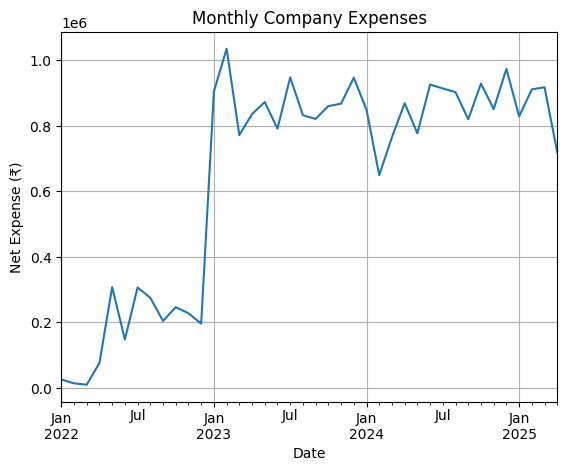

ADF Statistic: -3.3024289343845883
p-value: 0.014770249558364581
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=839.652, Time=7.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=836.875, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=839.820, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=838.987, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=835.789, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=838.555, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=838.503, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=840.464, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=838.312, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=837.788, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=839.450, Time=1.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 12.385 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -416.894
Date:                Fri, 25 Apr 2025   AIC                            835.789
Time:                        09:49:32   BIC                            837.223
Sample:                    01-31-2022   HQIC                           836.256
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.719e+10   3.01e+09      9.028      0.000    2.13e+1

In [ ]:
# Load and clean data
df = pd.read_csv('generated_financial_data_5500.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
df['debit_amount'] = pd.to_numeric(df['debit_amount'], errors='coerce').fillna(0)
df['credit'] = pd.to_numeric(df.get('credit', 0), errors='coerce').fillna(0)

# Compute net expense
df['net_expense'] = df['debit_amount'] - df['credit']

# Set date as index
df.set_index('date', inplace=True)

# Resample to monthly data
monthly_expense = df['net_expense'].resample('M').sum()

# Plot the time series
monthly_expense.plot(title="Monthly Company Expenses")
plt.ylabel("Net Expense (₹)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

# Train-test split (80% train, 20% test)
split_index = int(len(monthly_expense) * 0.8)
train_data = monthly_expense[:split_index]
test_data = monthly_expense[split_index:]

# ADF test on training set
result = adfuller(train_data)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Train auto_arima on train_data only
model = auto_arima(
    train_data,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Show model summary
print(model.summary())

In [ ]:
import pandas as pd
import numpy as np

# Add date features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['quarter'] = df.index.quarter
df['is_month_end'] = df.index.is_month_end
df['is_quarter_end'] = df.index.month.isin([3, 6, 9, 12])
df['is_half_year_end'] = df.index.month.isin([6, 12])
df['is_fy_end'] = df.index.month == 12

# Custom fiscal period
def fiscal_periods(date):
    fiscal_year = date.year
    fiscal_quarter = (date.month - 1) // 3 + 1
    fiscal_half = 1 if date.month <= 6 else 2
    return pd.Series([fiscal_year, fiscal_quarter, fiscal_half], index=['fiscal_year', 'fiscal_quarter', 'fiscal_half'])

df[['fiscal_year', 'fiscal_quarter', 'fiscal_half']] = df.index.to_series().apply(fiscal_periods)

# Add income flag
df['is_income'] = df['credit'] > 0

# Monthly transaction volume
df['transaction_volume'] = 1
# Grouped monthly data
monthly_df = df.groupby([pd.Grouper(freq='MS'), 'group_name', 'account_name']).agg({
    'net_expense': 'sum',
    'transaction_volume': 'sum',
    'is_income': 'sum'
}).reset_index()

# Create a helper to compute rolling + lag
def add_lag_features(group):
    group = group.sort_values('date')  # Ensure sorted by time
    group['lag_1'] = group['net_expense'].shift(1)
    group['lag_2'] = group['net_expense'].shift(2)
    group['rolling_mean_3'] = group['net_expense'].rolling(3).mean()
    group['rolling_std_3'] = group['net_expense'].rolling(3).std()
    return group

# Apply to each group_name + account_name
monthly_df = monthly_df.groupby(['group_name', 'account_name']).apply(add_lag_features).reset_index(drop=True)

<ipython-input-3-4b1bc502226f>:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_df = monthly_df.groupby(['group_name', 'account_name']).apply(add_lag_features).reset_index(drop=True)


📊 1. Net Expense + 3-Month Rolling Mean What it shows:

Actual monthly spending vs. a smoothed average trend.

Why it’s useful:

Helps identify spikes or dips in expenses.

The rolling mean removes short-term noise → gives a clearer long-term trend.

Management can forecast better and avoid over-reaction to one-off anomalies.

Business use case:

"Why was February 2024's expense 3x the average? Was it an annual license fee? Should we plan for it again next year?"

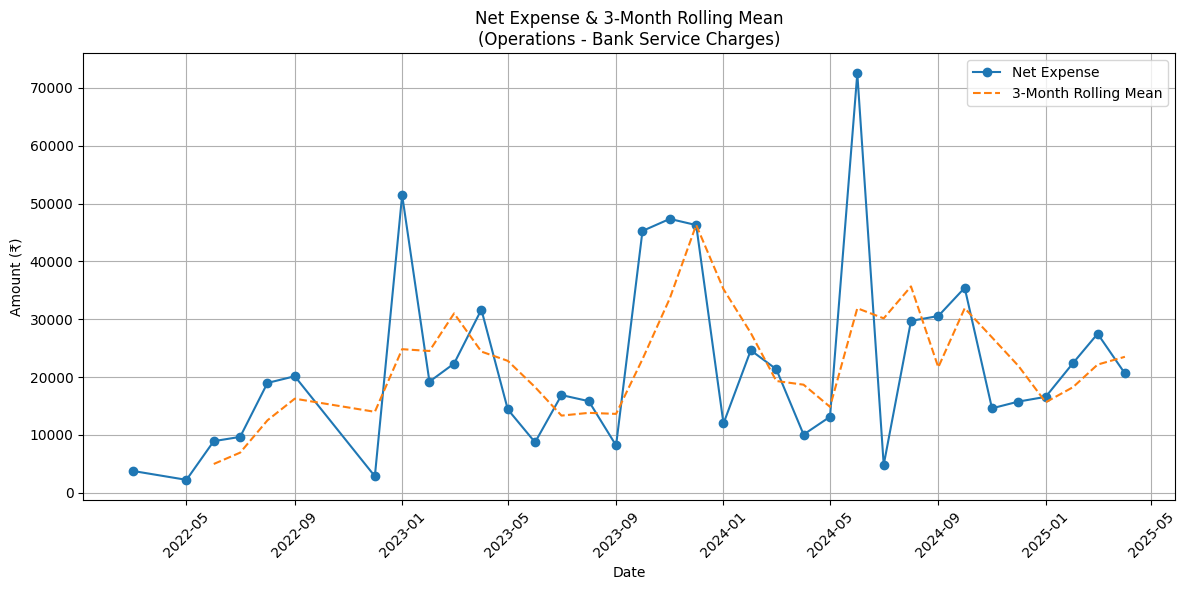

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot for one group_name + account_name
sample_df = monthly_df[(monthly_df['group_name'] == 'Operations') & (monthly_df['account_name'] == 'Bank Service Charges')]

plt.figure(figsize=(12, 6))
plt.plot(sample_df['date'], sample_df['net_expense'], label='Net Expense', marker='o')
plt.plot(sample_df['date'], sample_df['rolling_mean_3'], label='3-Month Rolling Mean', linestyle='--')
plt.title('Net Expense & 3-Month Rolling Mean\n(Operations - Bank Service Charges)')
plt.xlabel('Date')
plt.ylabel('Amount (₹)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📈 2. Transaction Volume Over Time What it shows:

Number of individual transactions per month.

Why it’s useful:

Explains sudden cost increases (many small transactions vs. one large).

Flags operational inefficiencies — too many small expenses may need consolidation.

Helpful in fraud detection — unexpected spikes in transaction count can be suspicious.

Business use case:

"April had the same expense as March, but 3x the transactions. Are we splitting purchases unnecessarily?"

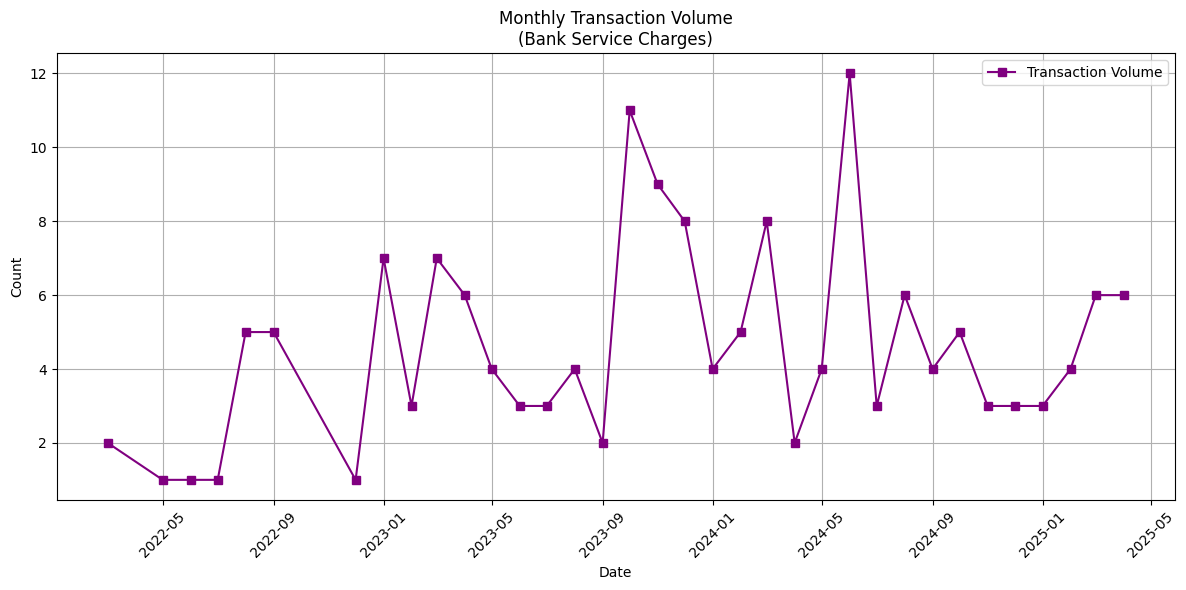

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sample_df['date'], sample_df['transaction_volume'], label='Transaction Volume', color='purple', marker='s')
plt.title('Monthly Transaction Volume\n(Bank Service Charges)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📉 3. Rolling Standard Deviation (Volatility) What it shows:

Fluctuation level in monthly expenses — higher std dev = less predictable.

Why it’s useful:

Helps assess expense consistency.

Departments with high volatility might need stricter budgets or contingency funds.

Can prioritize risk management.

Business use case:

"HR department expenses are unpredictable. We should consider a buffer or a cap."

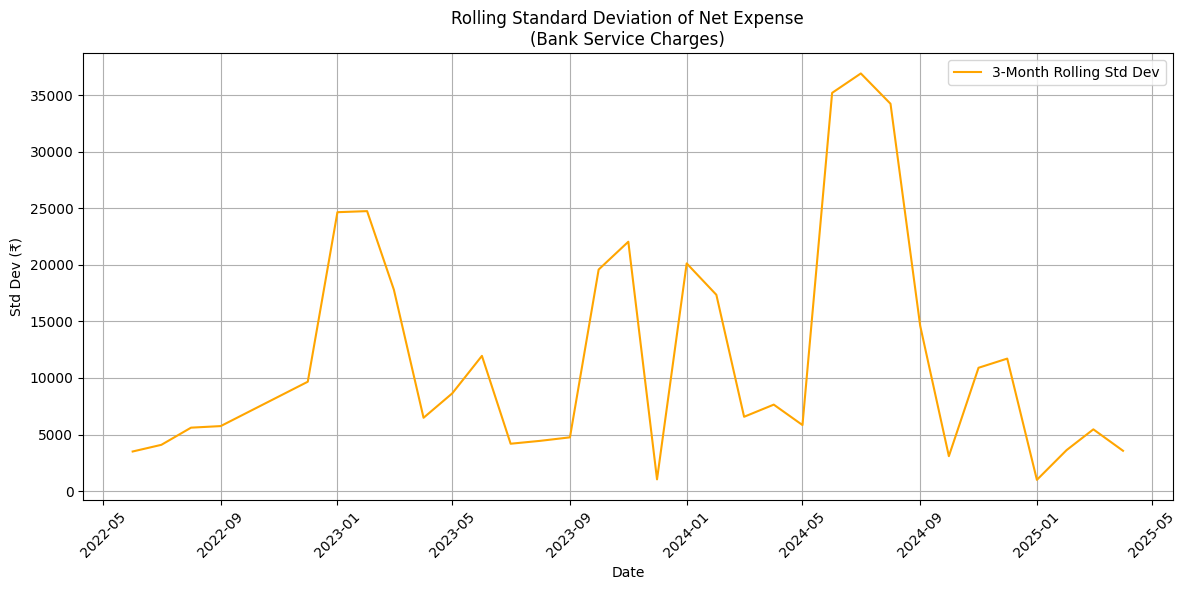

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sample_df['date'], sample_df['rolling_std_3'], label='3-Month Rolling Std Dev', color='orange')
plt.title('Rolling Standard Deviation of Net Expense\n(Bank Service Charges)')
plt.xlabel('Date')
plt.ylabel('Std Dev (₹)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Example: Filter for "Operations" - "Bank Service Charges"
filtered_df = monthly_df[
    (monthly_df['group_name'] == 'Operations') &
    (monthly_df['account_name'] == 'Bank Service Charges')
].copy()

# Set date as index
filtered_df.set_index('date', inplace=True)

# Make sure index is sorted
filtered_df = filtered_df.sort_index()



### 🔄 What is this all about?

We’re trying to build a **SARIMA model** to **predict future expenses**, like forecasting how much you’ll spend next month based on past months.

But to build the model, we need to choose four things:

1. **AR** (AutoRegressive part)
2. **MA** (Moving Average part)
3. **d** (Differencing to remove trend)
4. **Seasonality** (repeats every few months?)

And the ACF/PACF plot helps us pick those values. Let’s break them down!

---

### 🔹 AR (AutoRegressive): Suggested Value = **1**

**Means:** “Does this month’s value depend on the last month?”

- In your PACF plot (Partial Autocorrelation), the **bar at lag 1 is high**, but after that, the bars are low.
- That tells us: “This month is kind of like last month, but **not influenced much by months before that**.”

**So, we say: AR = 1** (we only need to look 1 step back).

🧠 Think of it like: “If I know how much I spent last month, I can guess this month well.”

---

### 🔹 MA (Moving Average): Suggested Value = **1 or 0**

**Means:** “How much does the error (random surprise) from the past months affect this month?”

- In the ACF plot (Autocorrelation), the first bar (lag 1) is strong, then it **quickly drops**.
- That means maybe there’s a bit of influence from **recent surprises**, but it doesn’t last.

**So, MA = 1 (or 0 if you're unsure)**.

🧠 Think of it like: “If I spent ₹2,000 more than expected last month, I might spend similarly this month too.”

---

### 🔹 d (Differencing): Suggested Value = **0 or 1**

**Means:** “Do I need to remove a trend (like steadily increasing expenses)?”

- If your expenses are **steadily going up or down**, we do **d = 1** to remove that trend.
- If they look **flat or random**, we use **d = 0**.

👉 You can check this visually using:
```python
monthly_data['debit_amount'].plot(title="Monthly Expenses Trend")
```

If the line looks like it's **climbing or falling**, use `d = 1`.  
If it looks more **bumpy but flat**, use `d = 0`.

🧠 Like: “Are my expenses growing over time? If yes, subtract previous month to make it flat.”

---

### 🔹 Seasonality: Suggested = **None or Weak**

**Means:** “Does a pattern repeat every 3, 6, or 12 months?”

- Your plots didn’t show **regular repeating spikes** at specific lags like 6 or 12, so **probably no strong seasonality**.
- If seasonality were strong, you’d see repeating bars at lags like 12 (1 year), 6 (half-year), etc.

🧠 Like: “Do I always spend more in December? If yes, add seasonality.”

---

### 🎯 FINAL TAKEAWAY

Based on your plots, a **simple model** you can start with:

```python
order = (1, 0, 1)  # ARIMA part: AR=1, d=0, MA=1
seasonal_order = (0, 0, 0, 12)  # No strong seasonality
```

This means:
- Look 1 step back in time (`AR`)
- Consider recent errors (`MA`)
- Don’t worry about long-term trends or repeating seasonal patterns yet.

---


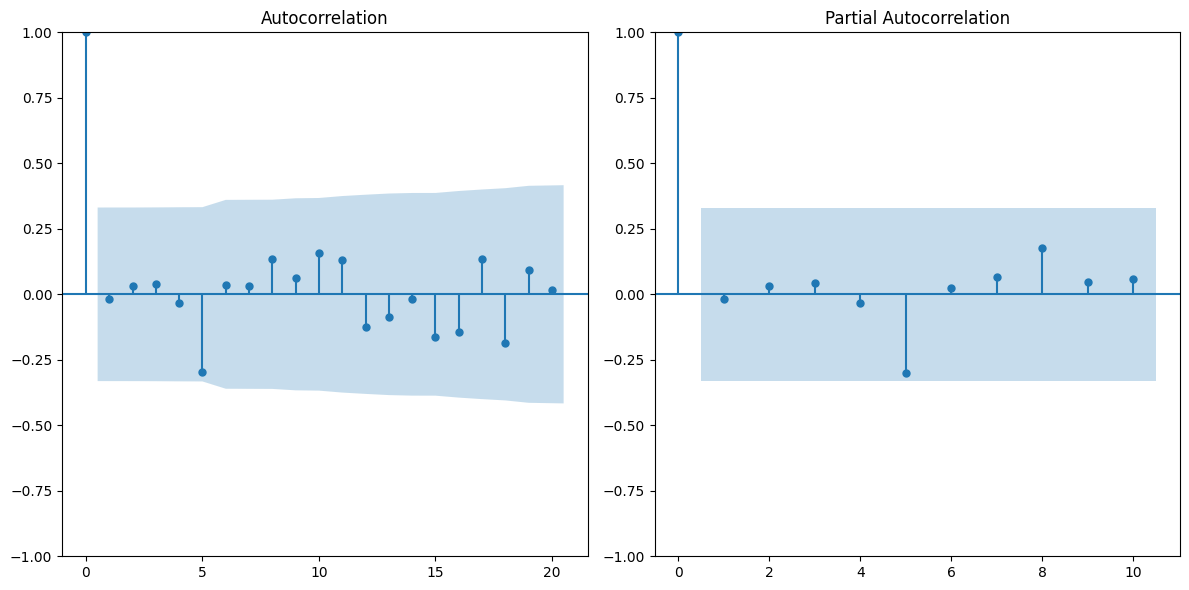

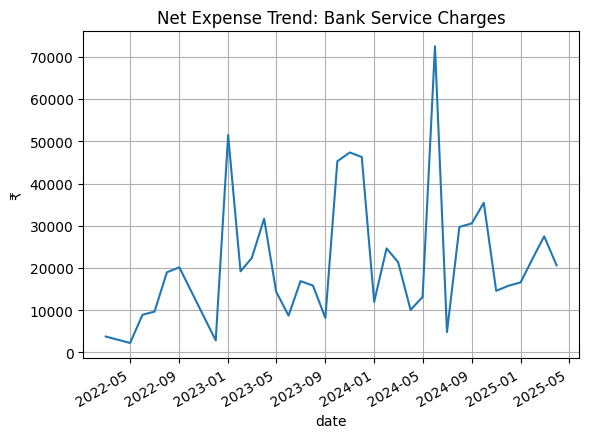

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check if enough data points
n = len(filtered_df)
if n >= 5:  # ensure you have enough data
    plt.figure(figsize=(12, 6))

    # ACF Plot
    plt.subplot(121)
    plot_acf(filtered_df['net_expense'], ax=plt.gca(), lags=min(n-1, 20))

    # PACF Plot
    plt.subplot(122)
    plot_pacf(filtered_df['net_expense'], ax=plt.gca(), lags=min(n // 2, 10))

    plt.tight_layout()
    plt.show()

    # Trend Line
    filtered_df['net_expense'].plot(title=f"Net Expense Trend: {filtered_df['account_name'].iloc[0]}")
    plt.ylabel("₹")
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points for ACF/PACF.")


1. ACF (Autocorrelation Function) Plot

Shows how strongly a value in your time series (e.g., "Debit Amount in January 2022") is correlated with its past values (e.g., "Debit Amount in December 2021").

Example: If the ACF at lag 1 is 0.75, it means today’s debit amount is 75% correlated with yesterday’s value.

This shows the correlation between the current value and its lagged values.

For example, if you're plotting sales data, ACF tells you how strongly this month’s expense is related to last month, 2 months ago, etc.

Peaks at certain lags suggest a pattern or trend over time.

Helps you decide how many MA (Moving Average) terms to include in an ARIMA model.

2. PACF (Partial Autocorrelation Function) Plot
Shows the direct relationship between a value and its lagged values, ignoring the influence of intermediate lags.

Example: PACF at lag 3 tells you the correlation between today’s value and the value 3 months ago, after removing the effect of lags 1 and 2.
Similar to ACF, but it controls for the influence of intermediate lags.

Example: PACF at lag 2 tells you how related this month is to two months ago after removing the effect of 1 month ago.

Helps decide how many AR (AutoRegressive) terms to use in ARIMA.


---

Think of ACF/PACF as "clues" to solve a mystery:

1.  
ACF tells you how far back the "memory" of your data goes.

2.   
PACF tells you which past months directly influence the current month, ignoring indirect effects.








In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMAX model with the chosen parameters
model = SARIMAX(
    filtered_df['net_expense'],
    order=(0, 1, 1),            # ARIMA part (p=1, d=1, q=1) Best model:  ARIMA(0,1,1)(0,0,0)[12]
    seasonal_order=(1, 1, 1, 12) # Seasonal part (P=1, D=1, Q=1, s=12 for yearly seasonality)
)

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        net_expense   No. Observations:                   35
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -251.999
Date:                            Fri, 25 Apr 2025   AIC                            511.998
Time:                                    09:52:11   BIC                            516.362
Sample:                                         0   HQIC                           513.026
                                             - 35                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7926      0.466     -1.701      0.089      -1.706       0.121
ar.S.L12      -0.5986      1.085   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
# Forecast for the next 3 months
monthly_forecast = results.forecast(steps=1)
print("Monthly Forecast for Next Month:", monthly_forecast)


Monthly Forecast for Next Month: 35    16657.642483
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Quarterly forecast (next 3 months)
quarterly_forecast = results.forecast(steps=3)
print("Quarterly Forecast:", quarterly_forecast)


Quarterly Forecast: 35    16657.642483
36    25007.994228
37    16940.364208
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Half-yearly forecast (next 6 months)
half_yearly_forecast = results.forecast(steps=6)
print("Half-Yearly Forecast:", half_yearly_forecast)


Half-Yearly Forecast: 35    16657.642483
36    25007.994228
37    16940.364208
38    21999.202810
39    17365.147902
40    43318.538894
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Yearly forecast (next 12 months)
yearly_forecast = results.forecast(steps=12)
print("Yearly Forecast:", yearly_forecast)


Yearly Forecast: 35    16657.642483
36    25007.994228
37    16940.364208
38    21999.202810
39    17365.147902
40    43318.538894
41    40781.029693
42    37949.037759
43    22831.808140
44    27628.108589
45    26944.451829
46    19669.196159
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freq

Best model: ((1, 1, 1), (0, 1, 1, 12), 33524.34903655297)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-14-c5a6fcacc2be>:82: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_data.index[-1], periods=forecast_months + 1, freq='M')[1:]


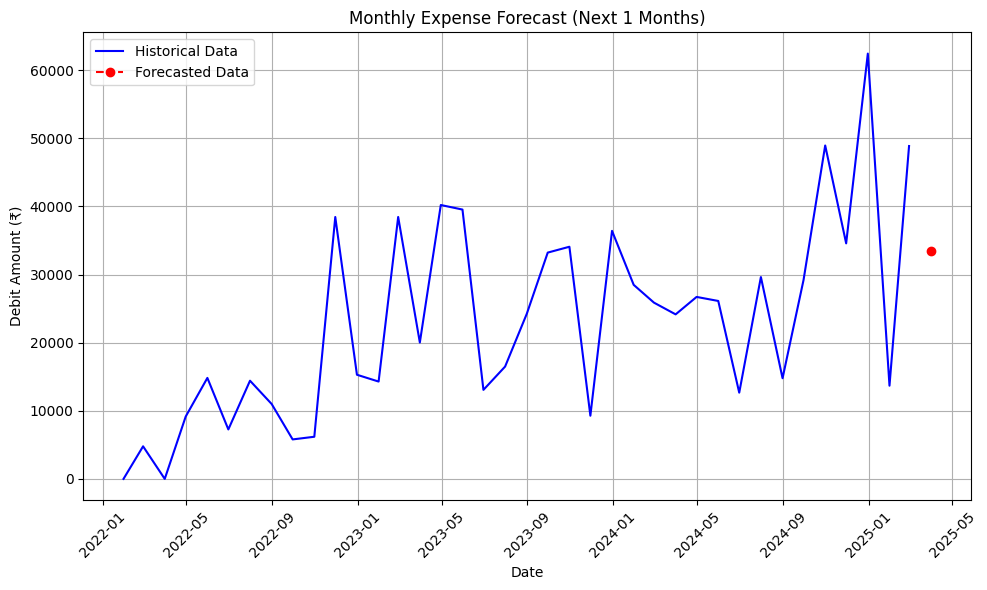

Month 1 Forecast: ₹33,524.35


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('generated_financial_data_5500.csv')

# Parse 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Set 'date' as the index
df.set_index('date', inplace=True)

# Group by date and sum debit_amount to remove duplicates
df = df.groupby(df.index).agg({'debit_amount': 'sum'})

# Set frequency to month-end
df = df.asfreq('ME')

# Group by month and sum debit_amount (monthly aggregation)
monthly_data = df['debit_amount'].resample('ME').sum().reset_index()

# Sort by date
monthly_data = monthly_data.sort_values('date')

# Split into train (till Feb 2025) and test (March 2025)
train_data = monthly_data[monthly_data['date'] < '2025-03-01']
test_data = monthly_data[monthly_data['date'] == '2025-03-31']  # March 2025

# Set date as index for training
train_data.set_index('date', inplace=True)

# Define SARIMA parameter combinations for grid search
orders = [(1, 1, 1), (2, 1, 1), (1, 1, 2)]
seasonal_orders = [(1, 1, 1, 12), (0, 1, 1, 12), (1, 0, 1, 12)]

best_score = float('inf')
best_model = None

# Loop over parameter combinations to find the best model
for order in orders:
    for seasonal in seasonal_orders:
        try:
            # Fit SARIMAX model
            model = SARIMAX(train_data['debit_amount'], order=order, seasonal_order=seasonal)
            results = model.fit(disp=False)

            # Forecast the next period
            forecast = results.forecast(steps=1)
            forecast_value = forecast.iloc[0]

            # Get actual value from test data
            actual_value = test_data['debit_amount'].values[0]

            # Calculate Mean Absolute Error (MAE) for model comparison
            mae = abs(forecast_value - actual_value)

            if mae < best_score:
                best_score = mae
                best_model = (order, seasonal, forecast_value)

        except Exception as e:
            print(f"Error with model (Order={order}, Seasonal={seasonal}): {e}")
            continue

# Output the best model found
print("Best model:", best_model)

# Forecast using the best model
order, seasonal, forecast_value = best_model

# Fit the best SARIMA model
best_sarima_model = SARIMAX(train_data['debit_amount'], order=order, seasonal_order=seasonal)
best_results = best_sarima_model.fit(disp=False)

# Forecast for the next 6 months
forecast_months = 1
forecast_values = best_results.forecast(steps=forecast_months)

# Create a forecast index for the next months
forecast_index = pd.date_range(start=train_data.index[-1], periods=forecast_months + 1, freq='M')[1:]

# Plot the forecasts
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(train_data.index, train_data['debit_amount'], label="Historical Data", color='blue')

# Plot forecasted data
plt.plot(forecast_index, forecast_values, label="Forecasted Data", color='red', linestyle='--', marker='o')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Debit Amount (₹)")
plt.title(f"Monthly Expense Forecast (Next {forecast_months} Months)")

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecasted values
for i, val in enumerate(forecast_values, 1):
    print(f"Month {i} Forecast: ₹{val:,.2f}")


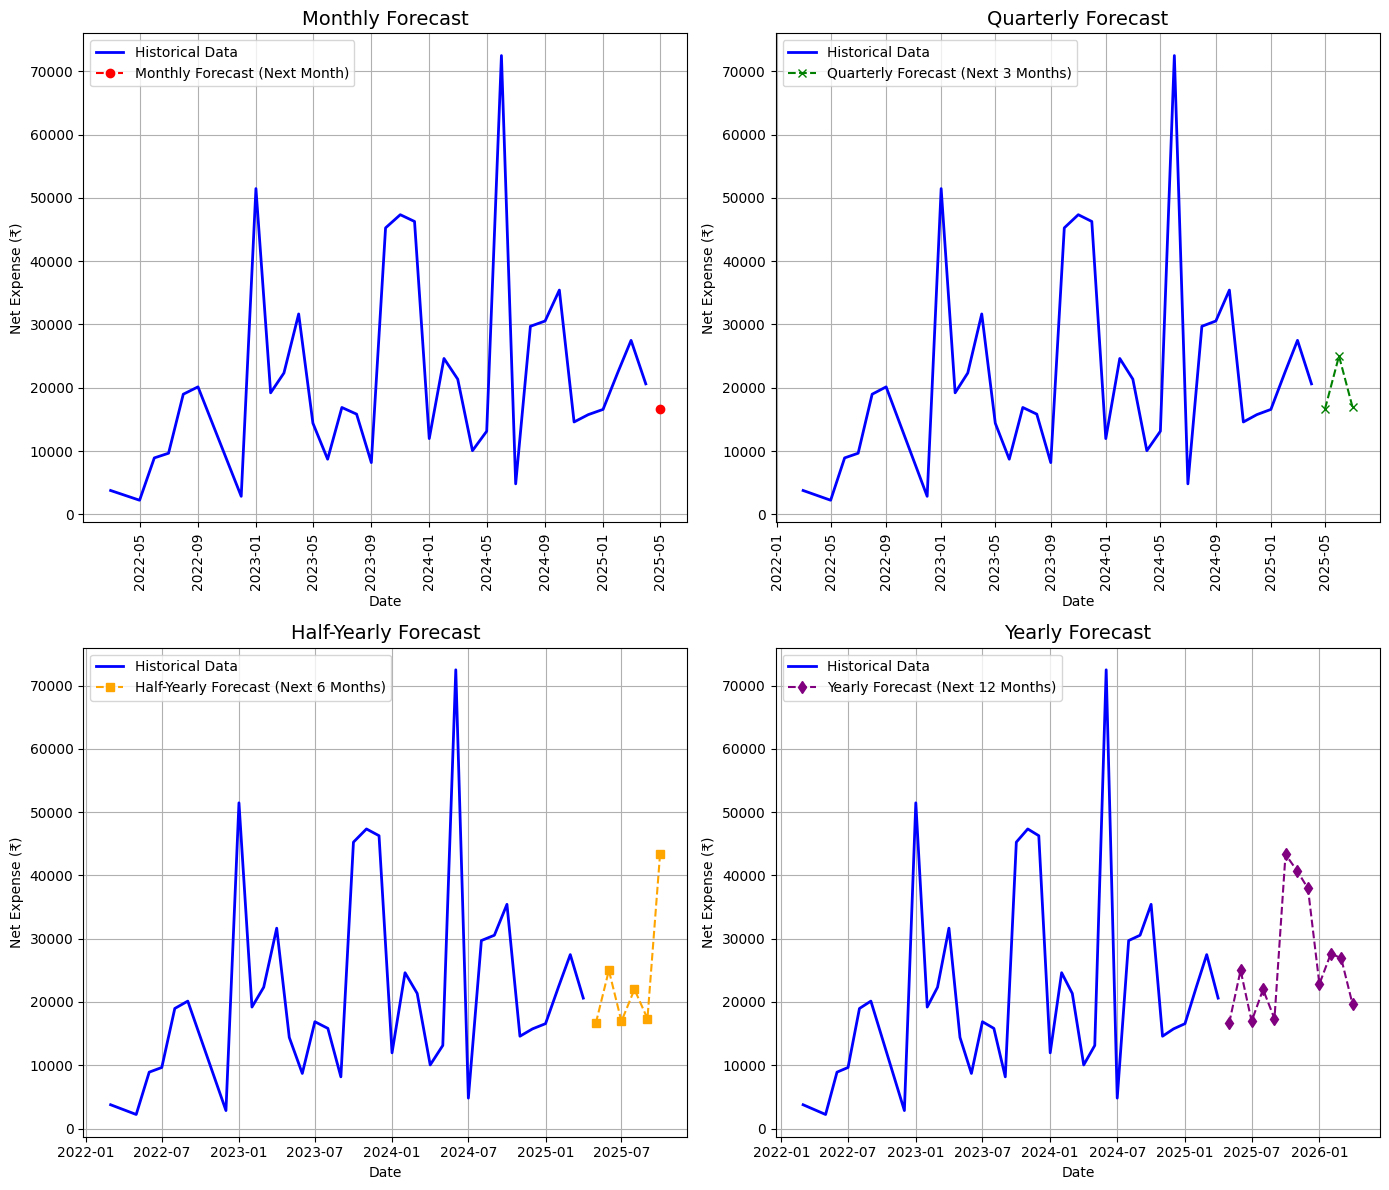

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create forecast index for each forecast period
forecast_index_monthly = pd.date_range(start=filtered_df.index[-1], periods=2, freq='MS')[1:]
forecast_index_quarterly = pd.date_range(start=filtered_df.index[-1], periods=4, freq='MS')[1:]
forecast_index_half_yearly = pd.date_range(start=filtered_df.index[-1], periods=7, freq='MS')[1:]
forecast_index_yearly = pd.date_range(start=filtered_df.index[-1], periods=13, freq='MS')[1:]

# Plot the detailed visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Monthly Forecast Plot
axes[0, 0].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 0].plot(forecast_index_monthly, monthly_forecast, label="Monthly Forecast (Next Month)", color='red', linestyle='--', marker='o')
axes[0, 0].set_title("Monthly Forecast", fontsize=14)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Net Expense (₹)")
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Quarterly Forecast Plot
axes[0, 1].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 1].plot(forecast_index_quarterly, quarterly_forecast, label="Quarterly Forecast (Next 3 Months)", color='green', linestyle='--', marker='x')
axes[0, 1].set_title("Quarterly Forecast", fontsize=14)
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Net Expense (₹)")
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=90)

# Half-Yearly Forecast Plot
axes[1, 0].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[1, 0].plot(forecast_index_half_yearly, half_yearly_forecast, label="Half-Yearly Forecast (Next 6 Months)", color='orange', linestyle='--', marker='s')
axes[1, 0].set_title("Half-Yearly Forecast", fontsize=14)
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Net Expense (₹)")
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Yearly Forecast Plot
axes[1, 1].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[1, 1].plot(forecast_index_yearly, yearly_forecast, label="Yearly Forecast (Next 12 Months)", color='purple', linestyle='--', marker='d')
axes[1, 1].set_title("Yearly Forecast", fontsize=14)
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Net Expense (₹)")
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


MONTHLY FORECAST

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('generated_financial_data_5500.csv')

# Parse 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Set 'date' as the index
df.set_index('date', inplace=True)

# Group by date and sum debit_amount to remove duplicates
df = df.groupby(df.index).agg({'debit_amount': 'sum'})

# Set frequency to month-end
df = df.asfreq('ME')

# Group by month and sum debit_amount (monthly aggregation)
monthly_data = df['debit_amount'].resample('ME').sum().reset_index()

# Sort by date
monthly_data = monthly_data.sort_values('date')

# Split into train (till Feb 2025) and test (March 2025)
train_data = monthly_data[monthly_data['date'] < '2025-03-01']
test_data = monthly_data[monthly_data['date'] == '2025-03-31']

# Set date as index for training
train_data.set_index('date', inplace=True)

# Define SARIMA parameter combinations for grid search
orders = [(1, 1, 1), (2, 1, 1), (1, 1, 2)]
seasonal_orders = [(1, 1, 1, 12), (0, 1, 1, 12), (1, 0, 1, 12)]

best_score = float('inf')
best_model = None

# Loop over parameter combinations to find the best model
for order in orders:
    for seasonal in seasonal_orders:
        try:
            # Fit SARIMAX model
            model = SARIMAX(train_data['debit_amount'], order=order, seasonal_order=seasonal)
            results = model.fit(disp=False)

            # Forecast the next period
            forecast = results.forecast(steps=1)
            forecast_value = forecast.iloc[0]

            # Get actual value from test data
            actual_value = test_data['debit_amount'].values[0]

            # Calculate Mean Absolute Error (MAE) for model comparison
            mae = abs(forecast_value - actual_value)

            if mae < best_score:
                best_score = mae
                best_model = (order, seasonal, forecast_value)

        except Exception as e:
            print(f"Error with model (Order={order}, Seasonal={seasonal}): {e}")
            continue

# Output the best model found
print("Best model:", best_model)

# Forecast using the best model
order, seasonal, forecast_value = best_model

# Fit the best SARIMA model
best_sarima_model = SARIMAX(train_data['debit_amount'], order=order, seasonal_order=seasonal)
best_results = best_sarima_model.fit(disp=False)

# Forecast for March 2025
forecast = best_results.forecast(steps=1)
forecast_value = forecast.iloc[0]

# Get the actual value from the test set
actual_value = test_data['debit_amount'].values[0]

# Calculate difference and accuracy
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Print the comparison table
print("Period\t\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"March 2025\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freq

Best model: ((1, 1, 1), (0, 1, 1, 12), 33524.34903655297)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Period		Forecasted Value	Actual Value		Difference		Accuracy %
March 2025	₹33,524.35		₹32,383.08		₹1,141.27		96.48%


In [ ]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Suppress warnings related to SARIMAX model fitting
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")

# Load the data
df = pd.read_csv('generated_financial_data_5500.csv')

# Parse 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Fill missing credit values with 0
df['credit'] = df['credit'].fillna(0)

# Create a new column for actual expense (debit - credit)
df['expense'] = df['debit_amount'] - df['credit']

# Filter for necessary columns (including the new 'expense' column)
df = df[['date', 'group_name', 'account_name', 'expense']]

# Prepare a list to collect results
results_list = []

# Get unique group-account combinations
grouped = df.groupby(['group_name', 'account_name'])

# Loop through each group-account combination
for (group, account), sub_df in grouped:
    # Prepare time series data for expense
    ts = sub_df.groupby('date')['expense'].sum().resample('ME').sum()

    # Drop NaNs and check for minimum required data points
    ts = ts.dropna()
    if len(ts) < 14:  # Needs at least 14 months for SARIMA(1,1,1)(1,1,1,12)
        continue

    # Split into train and test
    train = ts[ts.index < '2025-03-01']
    test = ts[ts.index == '2025-03-31']

    if test.empty or train.empty:
        continue

    try:
        # Fit SARIMAX model with fixed parameters (1, 1, 1) (1, 1, 1, 12)
        model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)

        # Forecasting for March 2025
        forecast = model_fit.forecast(steps=1)
        forecast_value = forecast.iloc[0]
        actual_value = test.values[0]

        # Calculate % change
        percent_change = ((forecast_value - actual_value) / actual_value) * 100

        # Append result
        results_list.append({
            'Group': group,
            'Account Name': account,
            'Actual Amount (₹)': actual_value,
            'Forecast Amount (₹)': forecast_value,
            '% Change': round(percent_change, 2)
        })

    except Exception as e:
        print(f"Error in {group} - {account}: {e}")
        continue

# Create DataFrame for the result
comparison_df = pd.DataFrame(results_list)

# Format and sort
comparison_df['Actual Amount (₹)'] = comparison_df['Actual Amount (₹)'].apply(lambda x: f"₹{x:,.2f}")
comparison_df['Forecast Amount (₹)'] = comparison_df['Forecast Amount (₹)'].apply(lambda x: f"₹{x:,.2f}")
comparison_df = comparison_df.sort_values('% Change', ascending=False)

# Display the table
print(comparison_df.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


     Group          Account Name Actual Amount (₹) Forecast Amount (₹)  % Change
    Travel Miscellaneous Expense         ₹7,946.06          ₹35,331.78    344.65
    Travel             Room Rent         ₹9,318.58          ₹40,095.95    330.28
        HR Miscellaneous Expense        ₹13,733.62          ₹52,980.25    285.77
        HR  Miscellaneous Income        ₹14,086.67          ₹48,432.14    243.82
 Ungrouped Miscellaneous Expense        ₹13,349.80          ₹37,734.82    182.66
        IT  Miscellaneous Income        ₹16,226.30          ₹34,356.83    111.74
    Travel  Miscellaneous Income        ₹20,319.60          ₹40,914.34    101.35
Operations     Employee Benefits        ₹15,111.99          ₹23,438.39     55.10
    Travel     Employee Benefits        ₹26,011.11          ₹40,007.83     53.81
 Ungrouped         FX Gain/ Loss        ₹12,610.92          ₹18,101.89     43.54
        HR     Employee Benefits        ₹34,563.45          ₹48,308.23     39.77
        HR                  

smoothening the data

In [ ]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Suppress SARIMAX warnings
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")

# Load the data
df = pd.read_csv('generated_financial_data_5500.csv')

# Parse dates
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Fill missing credits
df['credit'] = df['credit'].fillna(0)

# Create actual expense column
df['expense'] = df['debit_amount'] - df['credit']

# Keep necessary columns
df = df[['date', 'group_name', 'account_name', 'expense']]

# Prepare results list
results_list = []

# Group by group_name and account_name
grouped = df.groupby(['group_name', 'account_name'])

# Loop through each group-account combo
for (group, account), sub_df in grouped:
    # Monthly expense aggregation
    ts = sub_df.groupby('date')['expense'].sum().resample('ME').sum()

    # Drop NaNs
    ts = ts.dropna()

    # Smooth using rolling average (3-month window)
    ts_smoothed = ts.rolling(window=3, min_periods=1).mean()

    if len(ts_smoothed) < 14:
        continue

    # Split into train and test
    train = ts_smoothed[ts_smoothed.index < '2025-03-01']
    test = ts_smoothed[ts_smoothed.index == '2025-03-31']

    if test.empty or train.empty:
        continue

    try:
        # Fit SARIMAX
        model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)

        # Forecast March 2025
        forecast = model_fit.forecast(steps=1)
        forecast_value = forecast.iloc[0]
        actual_value = test.values[0]

        # Percent change
        percent_change = ((forecast_value - actual_value) / actual_value) * 100
        # Accuracy
        accuracy = 100 - abs(percent_change)
        # Add to results
        results_list.append({
            'Group': group,
            'Account Name': account,
            'Actual Amount (₹)': actual_value,
            'Forecast Amount (₹)': forecast_value,
            '% Change': round(percent_change, 2),
            'Accuracy (%)': round(accuracy, 2)
        })

    except Exception as e:
        print(f"Error in {group} - {account}: {e}")
        continue

# Create final comparison table
comparison_df = pd.DataFrame(results_list)

# Format and sort
if not comparison_df.empty:
    comparison_df['Actual Amount (₹)'] = comparison_df['Actual Amount (₹)'].apply(lambda x: f"₹{x:,.2f}")
    comparison_df['Forecast Amount (₹)'] = comparison_df['Forecast Amount (₹)'].apply(lambda x: f"₹{x:,.2f}")
    comparison_df = comparison_df.sort_values('% Change', ascending=False)

    print(comparison_df.to_string(index=False))
else:
    print("No forecast results were generated.")


     Group          Account Name Actual Amount (₹) Forecast Amount (₹)  % Change  Accuracy (%)
    Travel             Room Rent        ₹21,913.96          ₹38,676.19     76.49         23.51
 Ungrouped Miscellaneous Expense        ₹11,956.68          ₹20,799.98     73.96         26.04
        HR Miscellaneous Expense        ₹20,087.65          ₹34,886.76     73.67         26.33
    Travel Miscellaneous Expense        ₹24,603.98          ₹42,630.10     73.27         26.73
 Ungrouped                  Rent        ₹24,506.34          ₹37,599.94     53.43         46.57
    Travel  Miscellaneous Income        ₹26,171.79          ₹38,442.98     46.89         53.11
        HR                  Rent        ₹21,039.56          ₹28,412.95     35.05         64.95
        HR     Employee Benefits        ₹29,398.22          ₹39,124.69     33.09         66.91
        HR  Miscellaneous Income        ₹22,930.54          ₹29,952.28     30.62         69.38
        IT  Miscellaneous Income        ₹25,165.90

Time series for HR - Bank Service Charges: Length = 40
Train data for HR - Bank Service Charges: date
2022-01-01     1236.357206
2022-02-01        0.000000
2022-03-01        0.000000
2022-04-01        0.000000
2022-05-01    19890.350000
2022-06-01    10426.705150
2022-07-01     6957.520000
2022-08-01     5743.880000
2022-09-01        0.000000
2022-10-01        0.000000
2022-11-01    -2432.640000
2022-12-01     2015.550000
2023-01-01    28461.360000
2023-02-01    31080.170000
2023-03-01    10346.570000
2023-04-01    26389.250000
2023-05-01    38519.770000
2023-06-01    15749.480000
2023-07-01    19589.470000
2023-08-01     2951.740651
2023-09-01    32696.990000
2023-10-01     1971.530000
2023-11-01    18263.330000
2023-12-01    17114.710000
2024-01-01    31199.610000
2024-02-01    48362.530000
2024-03-01    17999.020000
2024-04-01    42970.180000
2024-05-01    50598.780000
2024-06-01    38174.870000
2024-07-01    29151.460000
2024-08-01    13771.110000
2024-09-01    36660.950000
2024-10

<ipython-input-19-4c85e0b59177>:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Error in Operations - Room Rent: Units 'M', 'Y', and 'y' are no longer supported, as they do not represent unambiguous timedelta values durations.
Time series for Travel - Bank Service Charges: Length = 34
Train data for Travel - Bank Service Charges: date
2022-07-01     6734.210000
2022-08-01    22540.010000
2022-09-01     7956.317411
2022-10-01        0.000000
2022-11-01        0.000000
2022-12-01    14964.980000
2023-01-01    28811.960000
2023-02-01    24498.735078
2023-03-01    31972.400000
2023-04-01    25583.090000
2023-05-01    11793.450000
2023-06-01    19606.270000
2023-07-01    28147.000000
2023-08-01    69022.830000
2023-09-01    32523.240000
2023-10-01     1485.870000
2023-11-01      693.500000
2023-12-01    11086.250000
2024-01-01     2770.310000
2024-02-01    20262.750000
2024-03-01        0.000000
2024-04-01    26318.210000
2024-05-01    21012.710000
2024-06-01    18676.150000
2024-07-01    36481.860000
2024-08-01    31521.550000
2024-09-01    14531.790000
2024-10-01    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error in Travel - Employee Benefits: Units 'M', 'Y', and 'y' are no longer supported, as they do not represent unambiguous timedelta values durations.
Time series for Travel - FX Gain/ Loss: Length = 38
Train data for Travel - FX Gain/ Loss: date
2022-03-01     3268.088840
2022-04-01        0.000000
2022-05-01     6524.120000
2022-06-01     1563.330000
2022-07-01      -50.360000
2022-08-01     6462.250000
2022-09-01     9021.213442
2022-10-01     6148.970000
2022-11-01    26669.730000
2022-12-01        0.000000
2023-01-01     5997.400000
2023-02-01    33346.960000
2023-03-01    17223.400000
2023-04-01    50562.090000
2023-05-01    18534.510000
2023-06-01     4381.090000
2023-07-01    16606.220000
2023-08-01    15627.039799
2023-09-01    19458.240000
2023-10-01    17361.790000
2023-11-01    50361.693899
2023-12-01    17872.412551
2024-01-01    27831.270000
2024-02-01        0.000000
2024-03-01    12681.770000
2024-04-01    18043.040000
2024-05-01    17942.790000
2024-06-01    32345.5800

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error in Travel - Miscellaneous Income: Units 'M', 'Y', and 'y' are no longer supported, as they do not represent unambiguous timedelta values durations.
Time series for Travel - Rent: Length = 36
Train data for Travel - Rent: date
2022-05-01     3838.530000
2022-06-01      947.270000
2022-07-01    14973.670269
2022-08-01        0.000000
2022-09-01        0.000000
2022-10-01     9654.390000
2022-11-01     2170.430000
2022-12-01     1009.850000
2023-01-01    25280.690000
2023-02-01    62422.894690
2023-03-01    18461.110000
2023-04-01    37379.535553
2023-05-01    25794.920000
2023-06-01    34612.740000
2023-07-01    32406.960000
2023-08-01    23709.880000
2023-09-01    21057.960000
2023-10-01     1466.470000
2023-11-01    13008.740000
2023-12-01    14554.950000
2024-01-01    13874.700000
2024-02-01     7746.780000
2024-03-01    22917.390000
2024-04-01    12219.790000
2024-05-01    21275.970000
2024-06-01     9793.380000
2024-07-01    38065.230000
2024-08-01    36153.940000
2024-09-01  

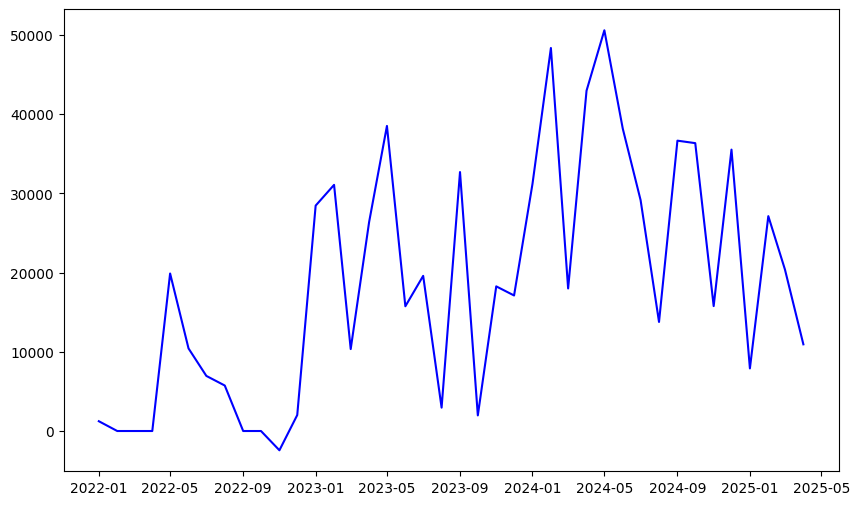

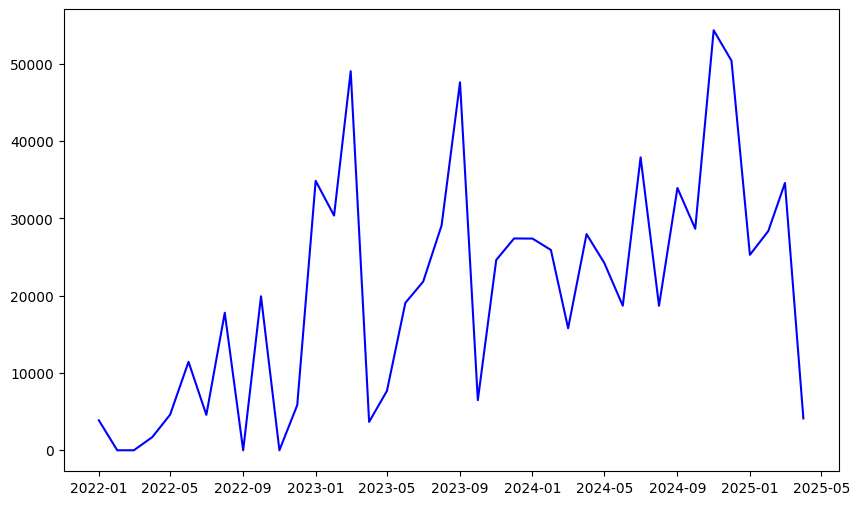

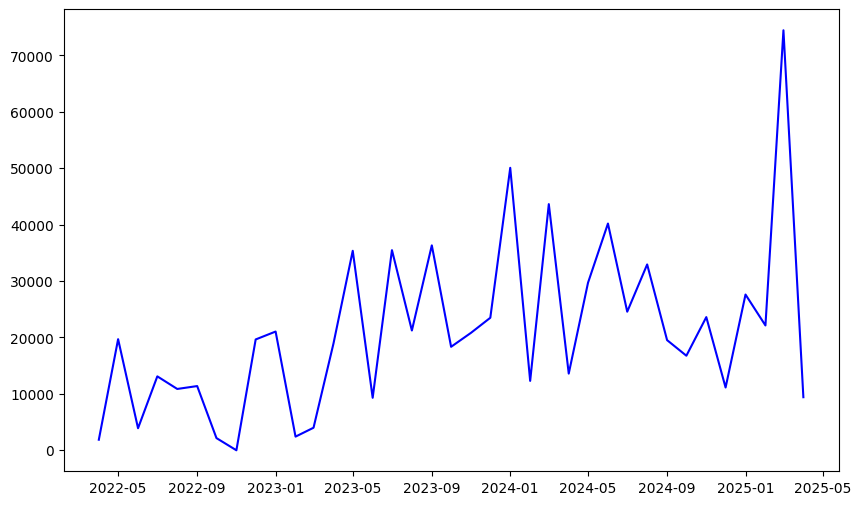

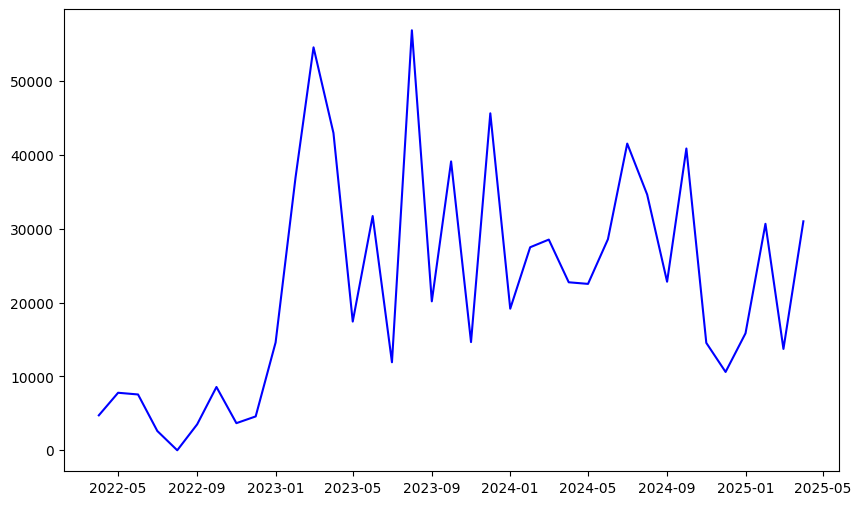

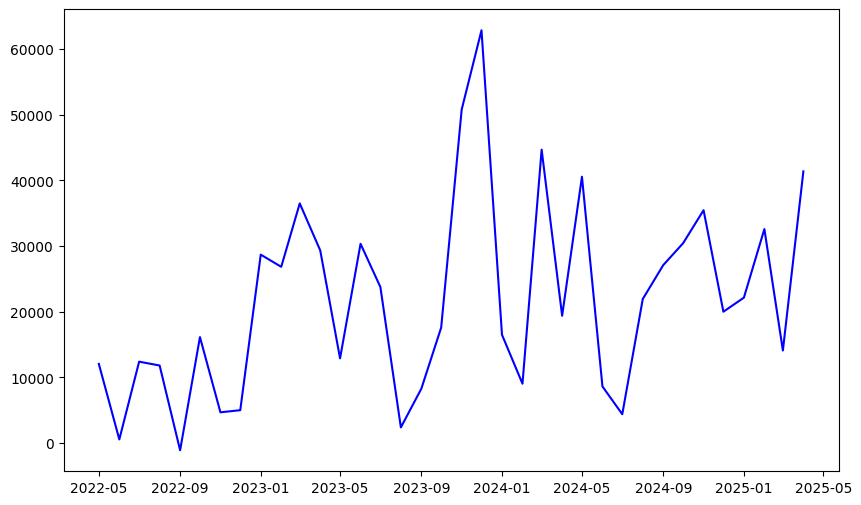

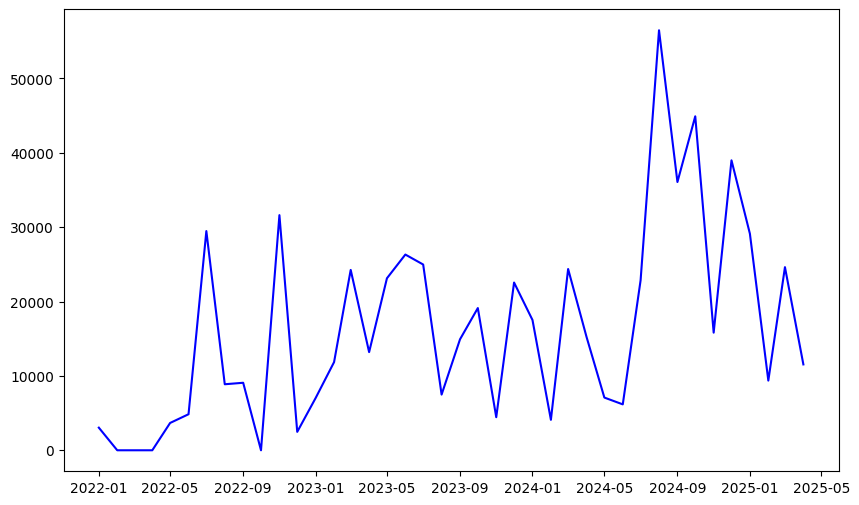

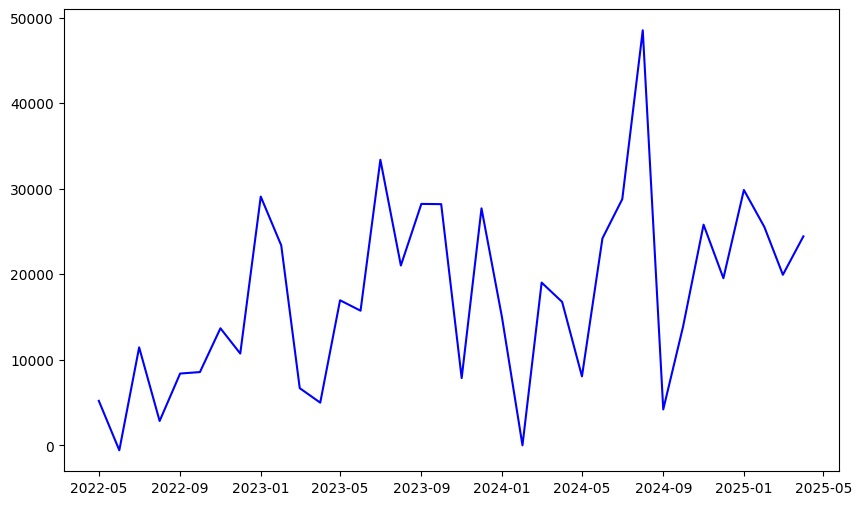

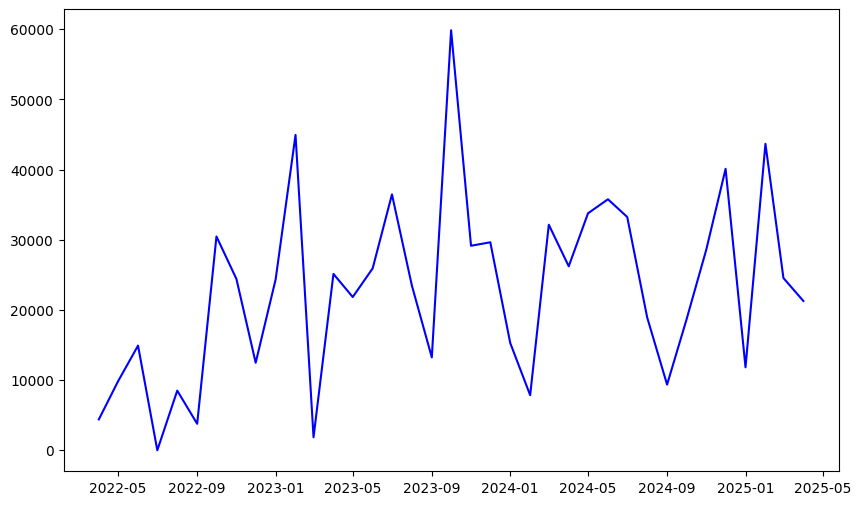

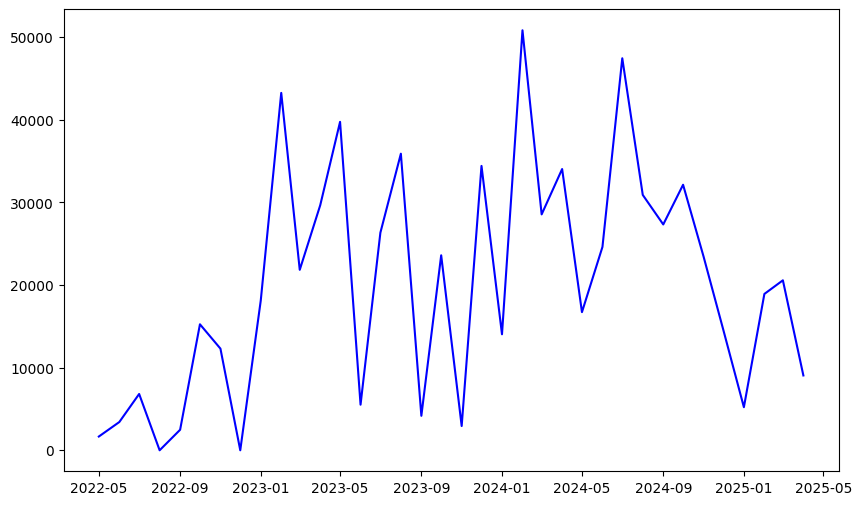

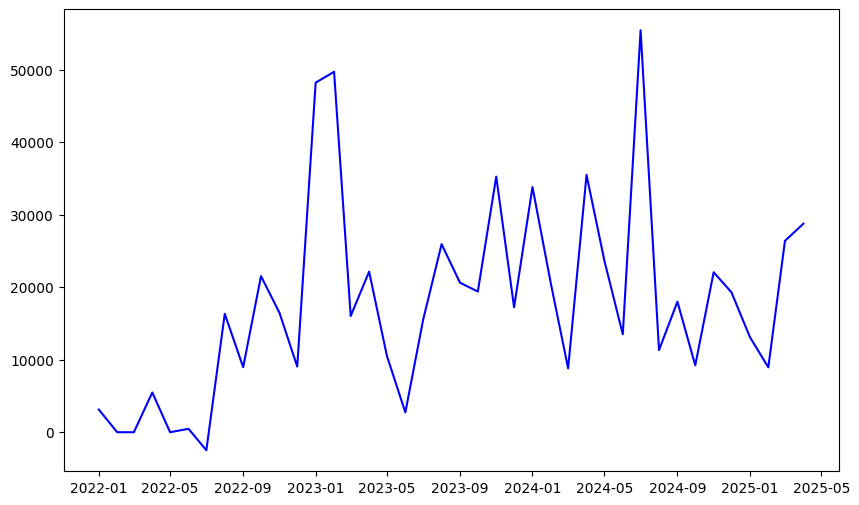

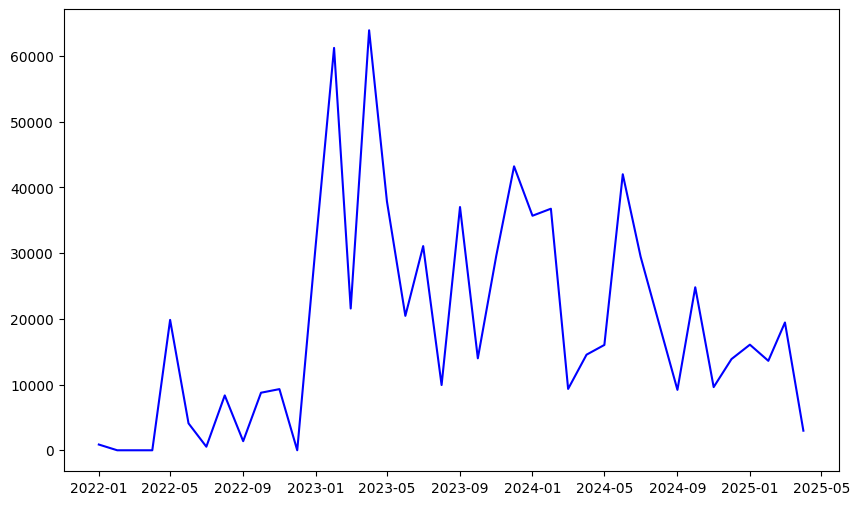

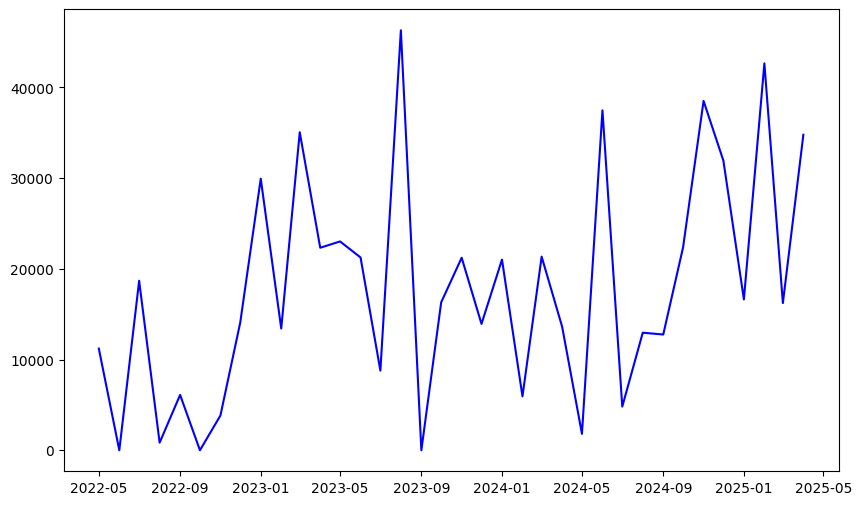

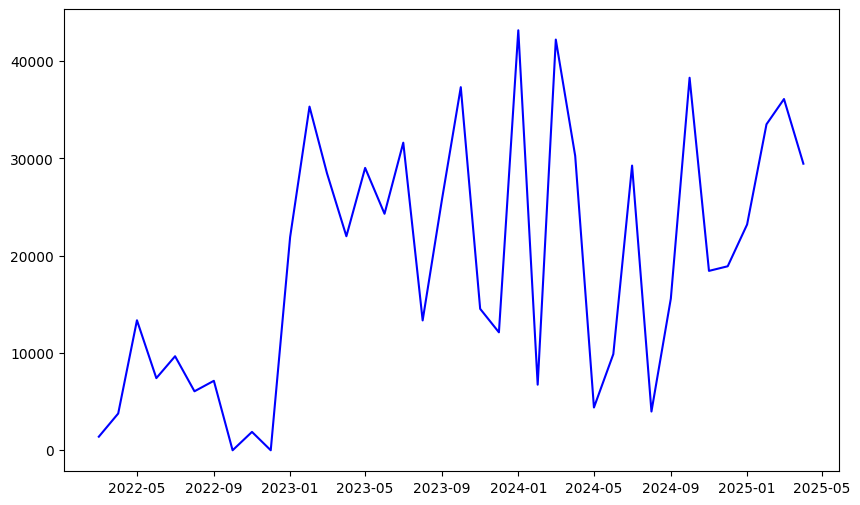

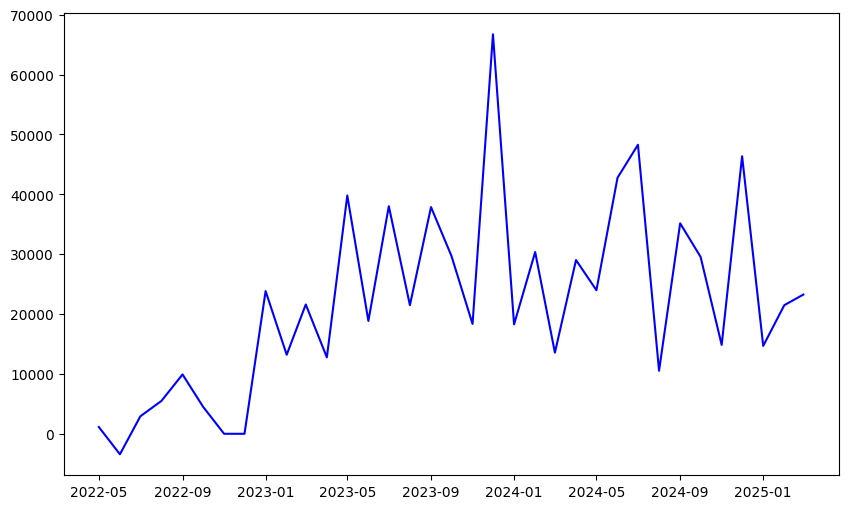

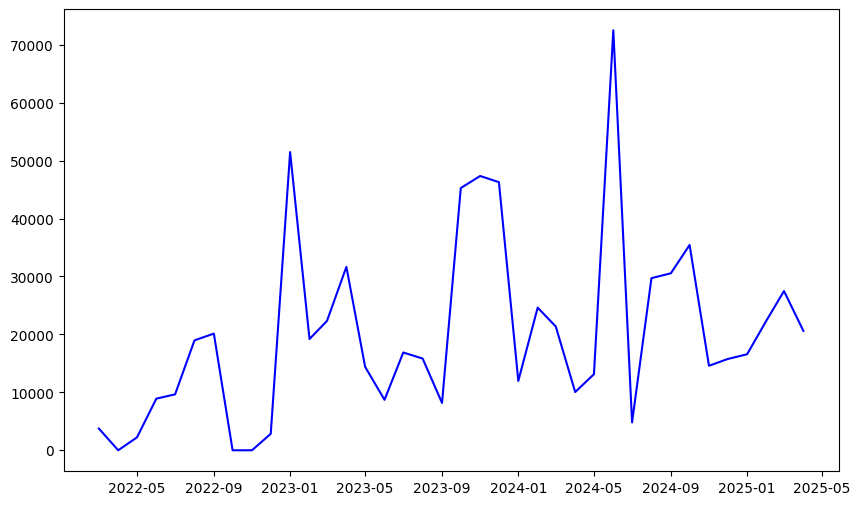

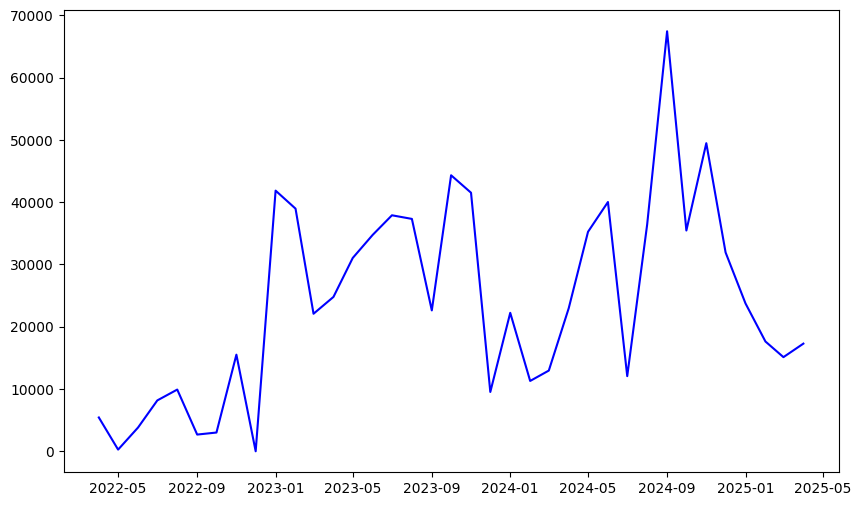

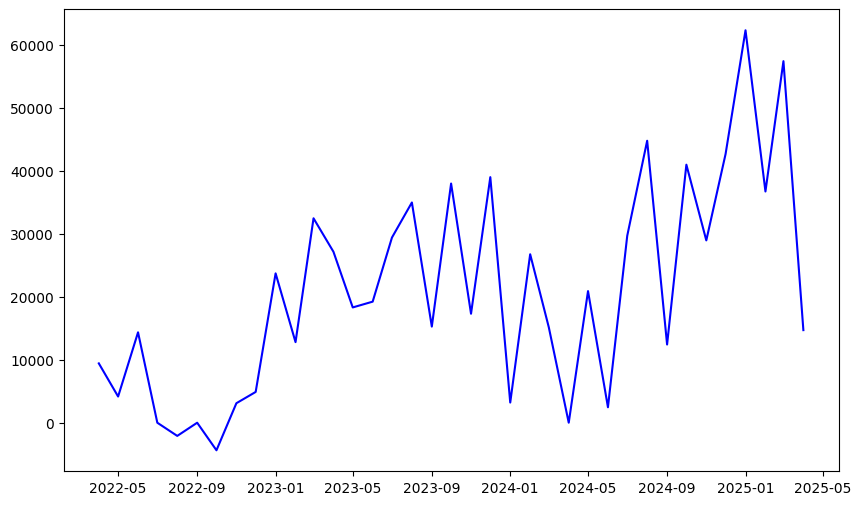

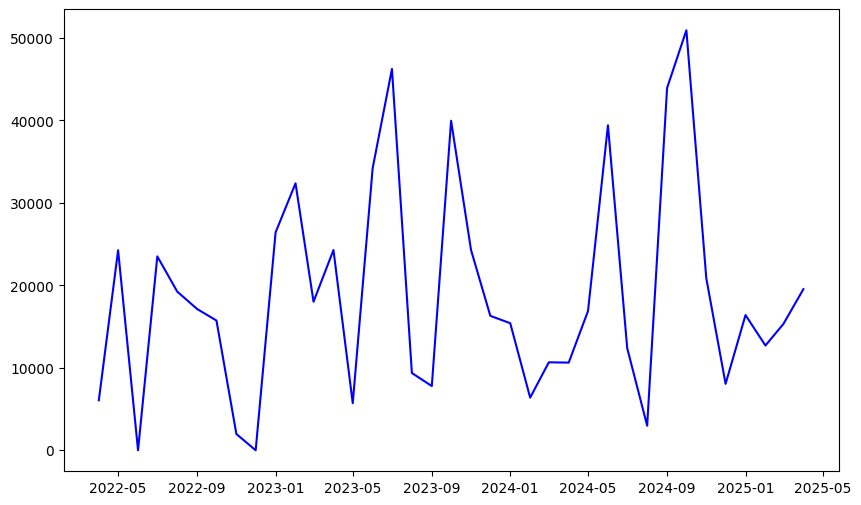

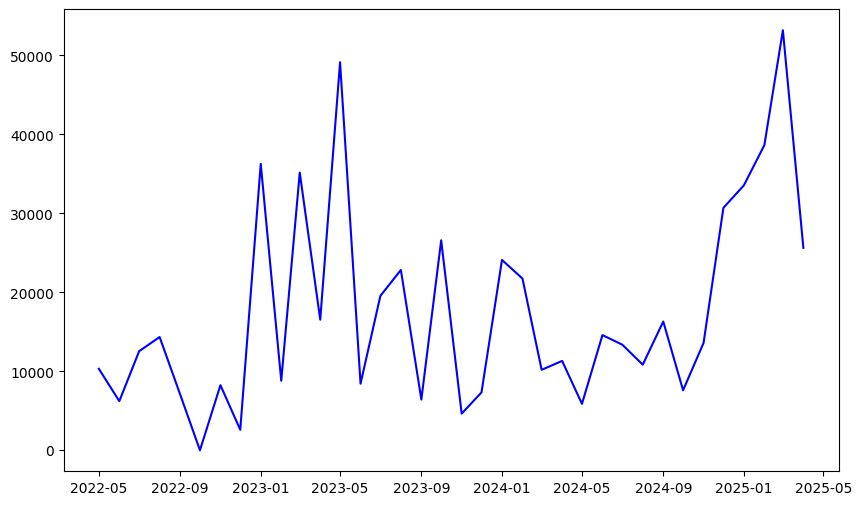

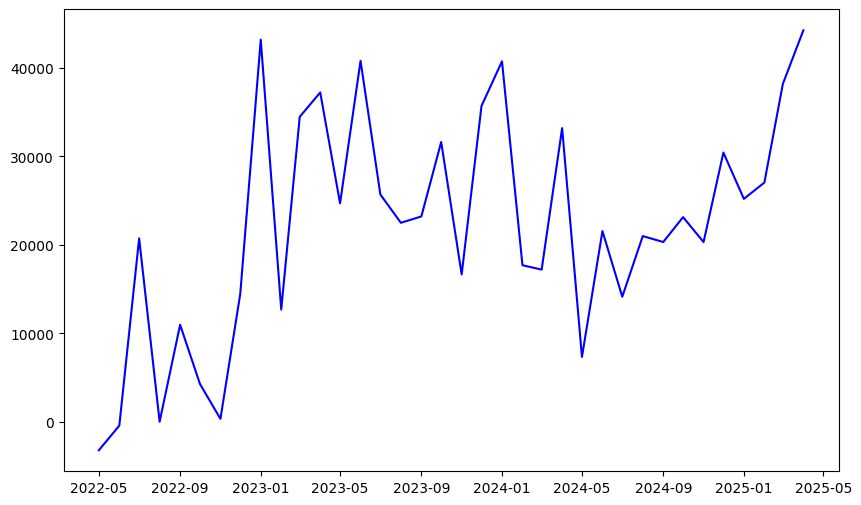

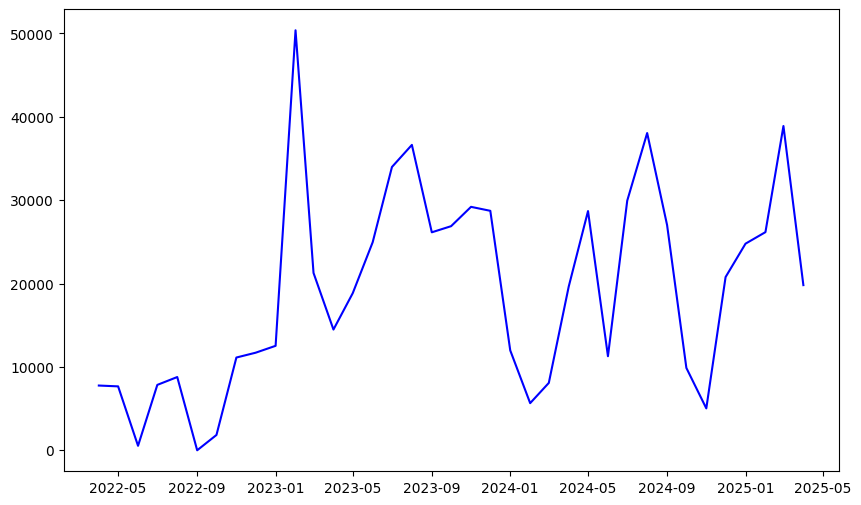

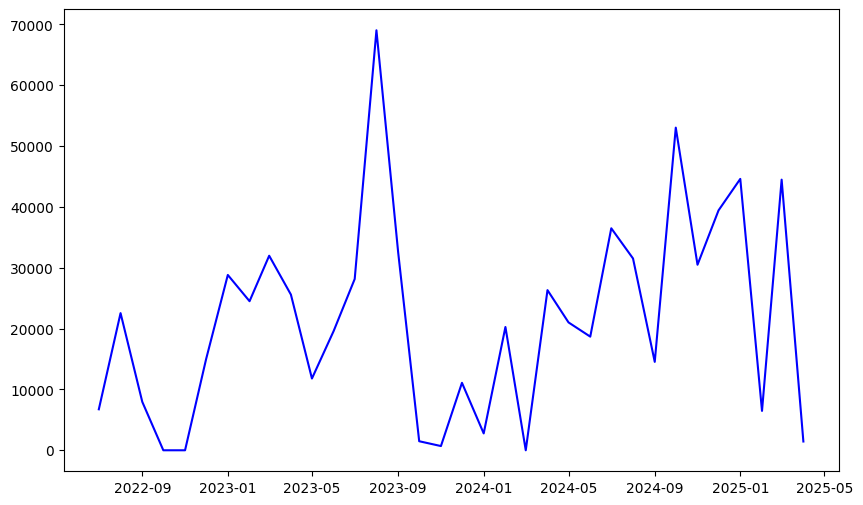

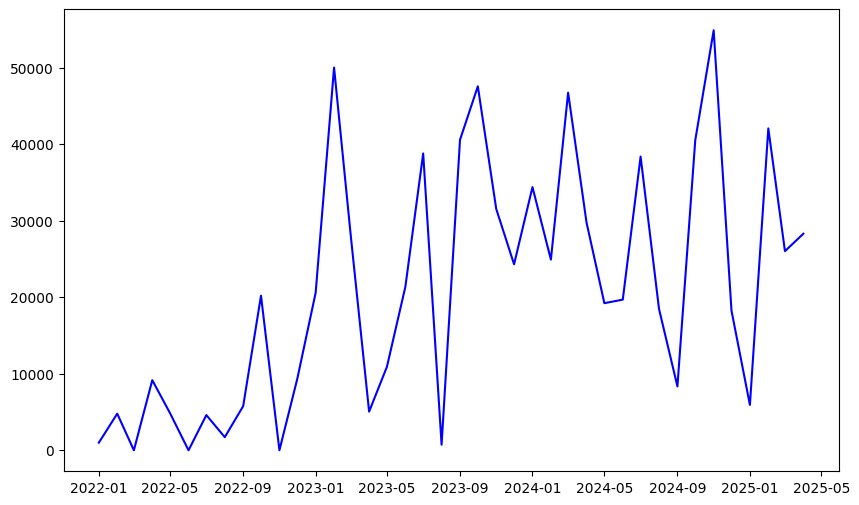

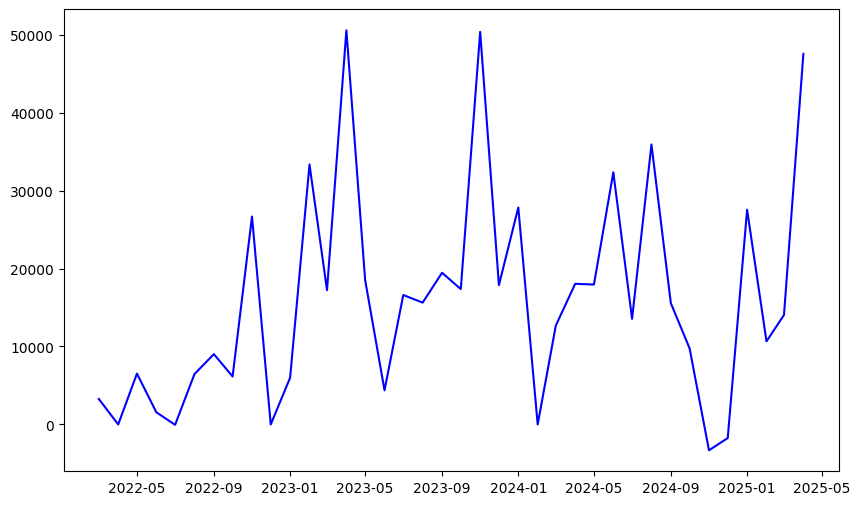

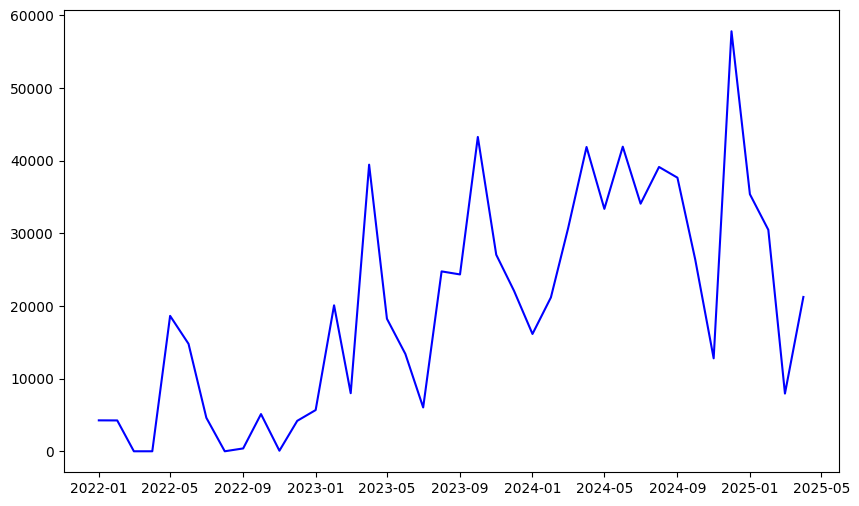

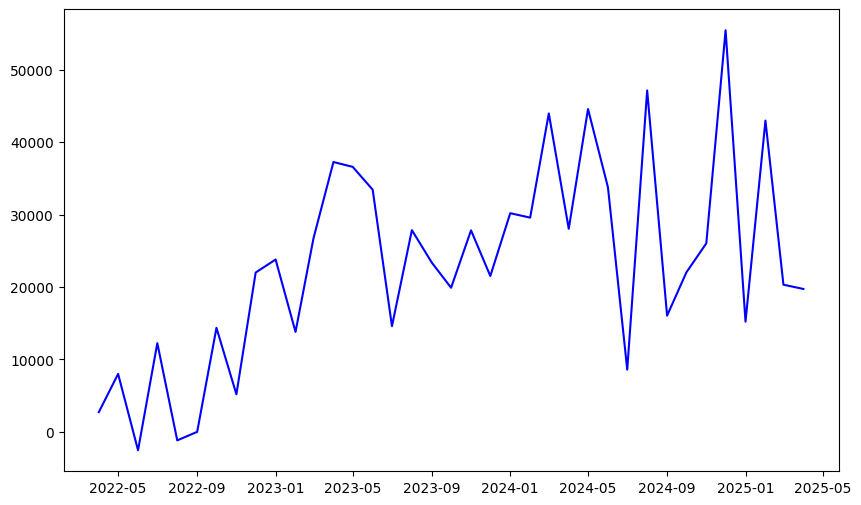

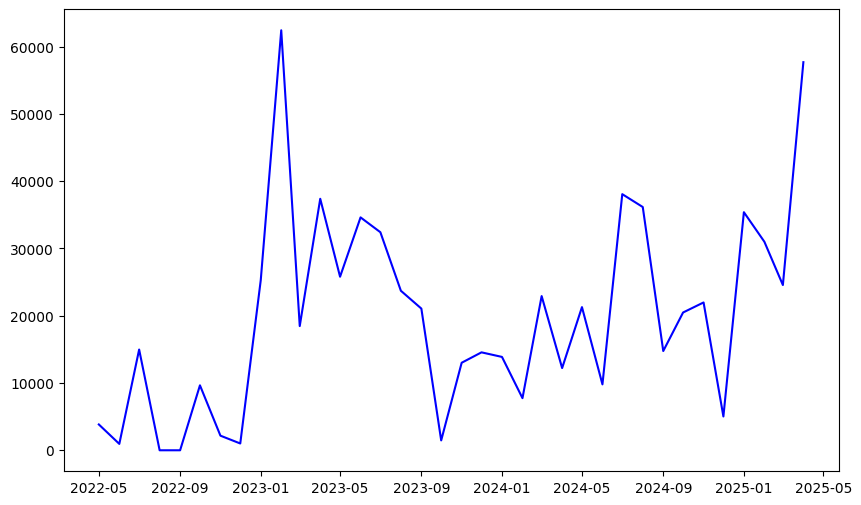

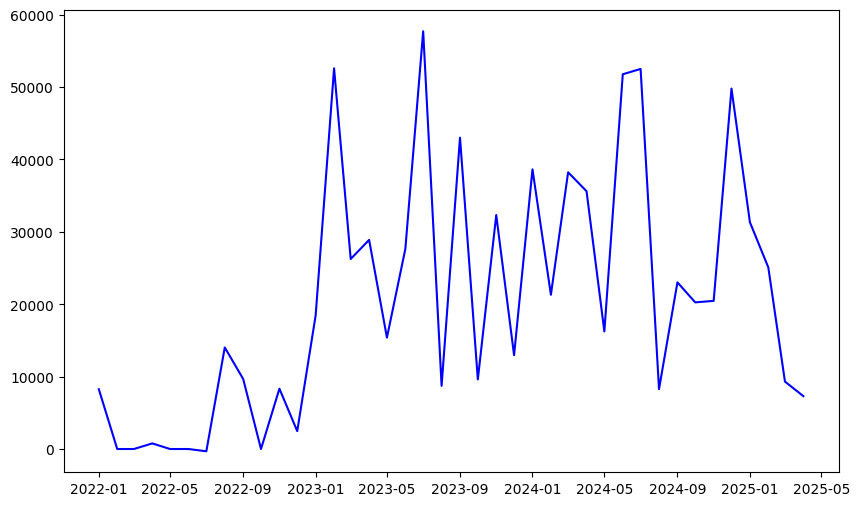

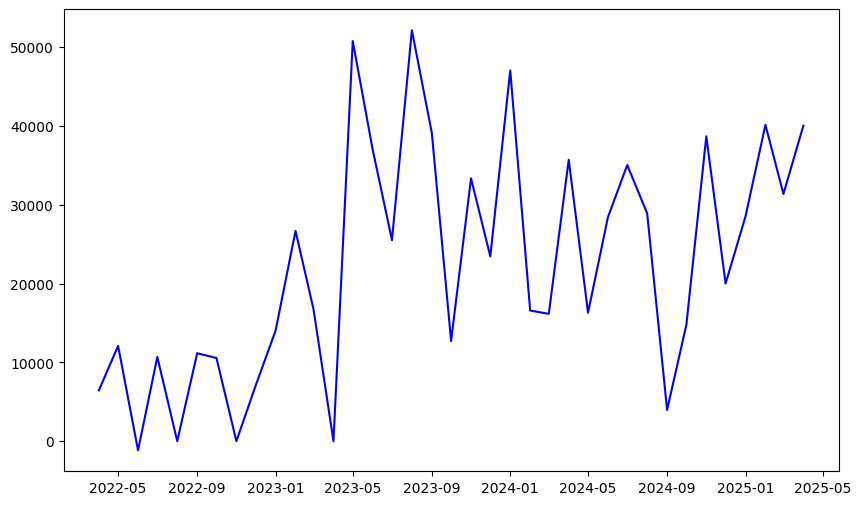

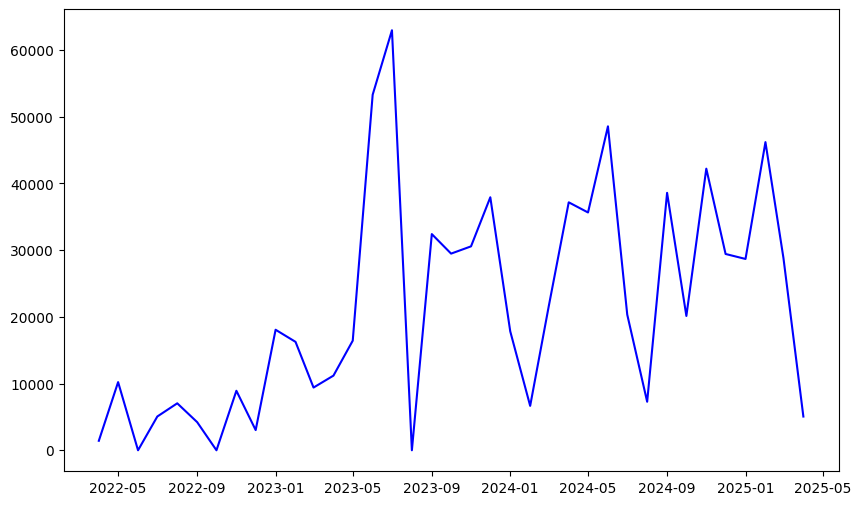

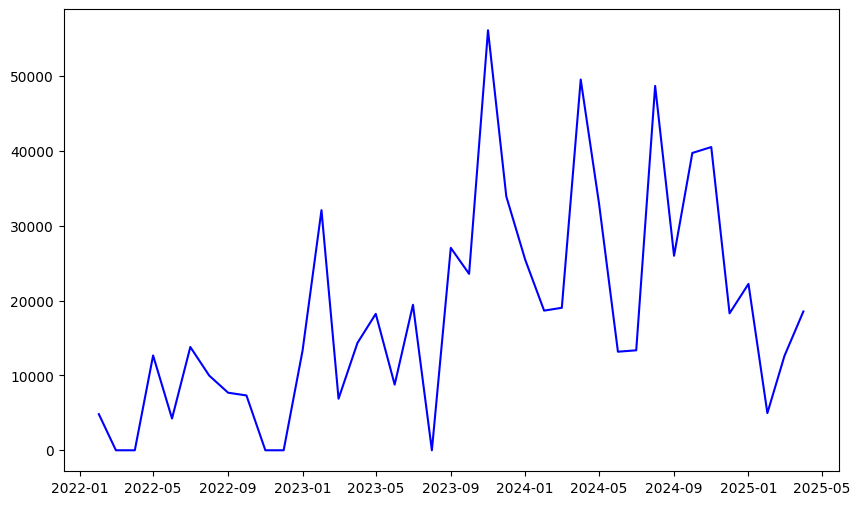

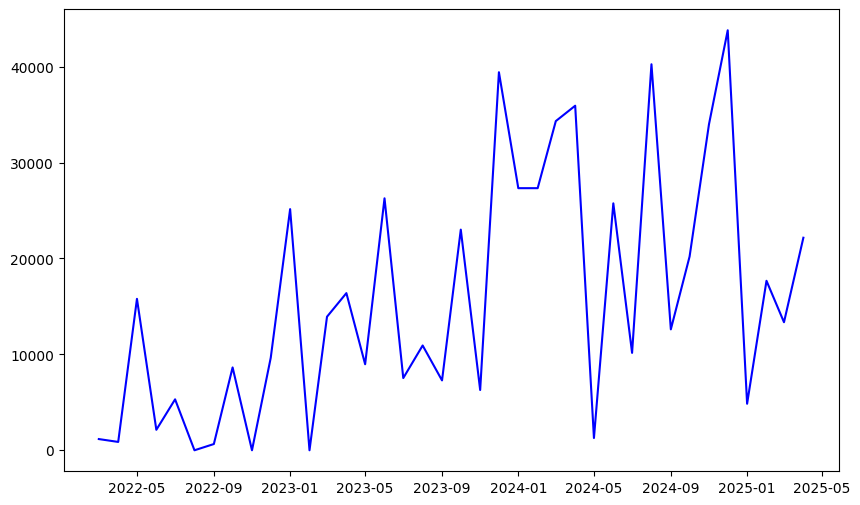

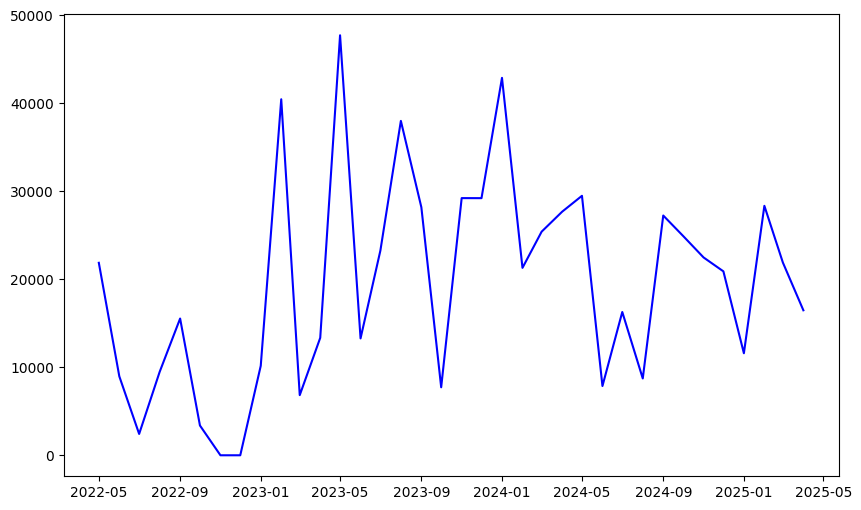

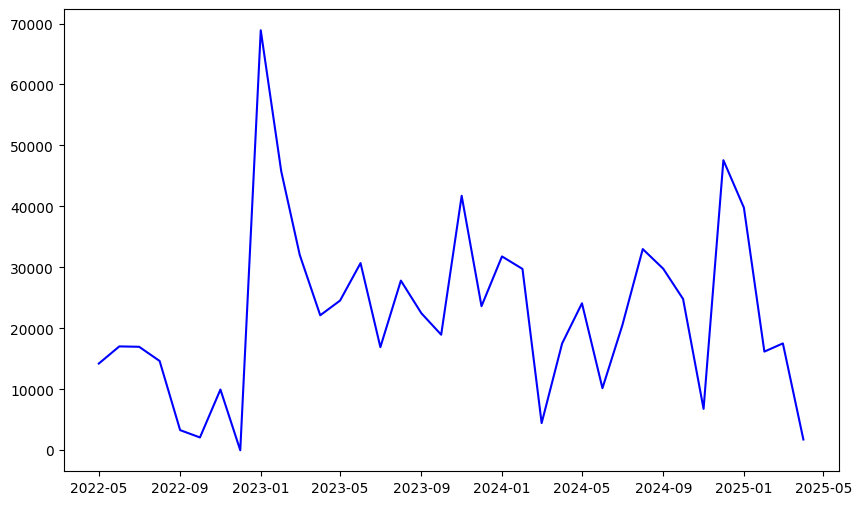

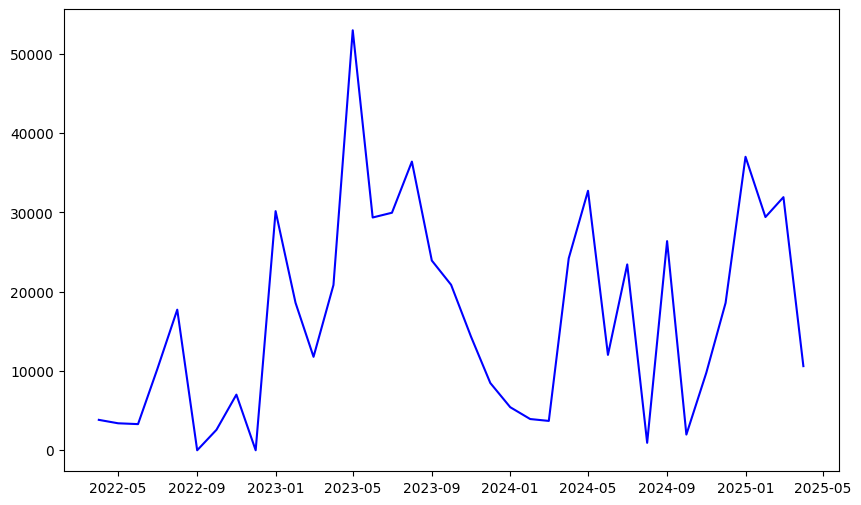

In [ ]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Suppress warnings related to SARIMAX model fitting
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")

# Load the data
df = pd.read_csv('generated_financial_data_5500.csv')

# Parse 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Fill missing credit values with 0
df['credit'] = df['credit'].fillna(0)

# Create a new column for actual expense (debit - credit)
df['expense'] = df['debit_amount'] - df['credit']

# Filter for necessary columns (including the new 'expense' column)
df = df[['date', 'group_name', 'account_name', 'expense']]

# Prepare a list to collect results
results_list = []

# Get unique group-account combinations
grouped = df.groupby(['group_name', 'account_name'])

# Loop through each group-account combination
for (group, account), sub_df in grouped:
    # Prepare time series data for expense
    ts = sub_df.groupby('date')['expense'].sum().resample('MS').sum()  # Changed 'ME' to 'MS'

    # Drop NaNs and check for minimum required data points
    ts = ts.dropna()

    # Debugging: Check the length of time series data
    print(f"Time series for {group} - {account}: Length = {len(ts)}")

    if len(ts) < 14:  # Needs at least 14 months for SARIMA(1,1,1)(1,1,1,12)
        print(f"Not enough data for {group} - {account} (Less than 14 points). Skipping...")
        continue

    # Temporarily adjust the test split date to ensure it gets data
    train = ts[ts.index < ts.index[-2]]  # Use last 2 months as test
    test = ts[ts.index[-2:]]  # Last 2 months as test data

    # Debugging: Check the split data
    print(f"Train data for {group} - {account}: {train}")
    print(f"Test data for {group} - {account}: {test}")

    if test.empty or train.empty:
        print(f"Empty train/test data for {group} - {account}. Skipping...")
        continue

    try:
        # Fit SARIMAX model with fixed parameters (1, 1, 1) (1, 1, 1, 12)
        model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)

        # Forecasting for the next period (e.g., next month)
        forecast = model_fit.forecast(steps=1)
        forecast_value = forecast.iloc[0]
        actual_value = test.values[0]

        # Calculate % change
        percent_change = ((forecast_value - actual_value) / actual_value) * 100

        # Append result
        results_list.append({
            'Group': group,
            'Account Name': account,
            'Actual Amount (₹)': actual_value,
            'Forecast Amount (₹)': forecast_value,
            '% Change': round(percent_change, 2)
        })

        # Debugging Visualization: Plot the actual and forecasted values
        plt.figure(figsize=(10, 6))
        plt.plot(ts, label="Actual", color="blue")

        # Forecasted value
        forecast_index = pd.date_range(ts.index[-1] + pd.Timedelta(1, 'M'), periods=1, freq='MS')  # Use 'MS'
        plt.plot(forecast_index, forecast, label="Forecast", color="red", marker='o')

        # Plot formatting
        plt.title(f"Actual vs Forecast for {group} - {account}")
        plt.xlabel('Date')
        plt.ylabel('Expense (₹)')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error in {group} - {account}: {e}")
        continue

# Check if results_list is populated
print("Results List Length:", len(results_list))  # Debugging line

# Create DataFrame for the result
if len(results_list) > 0:
    comparison_df = pd.DataFrame(results_list)

    # Check column names
    print("Columns in the DataFrame:", comparison_df.columns)  # Debugging line

    # Format and sort
    comparison_df['Actual Amount (₹)'] = comparison_df['Actual Amount (₹)'].apply(lambda x: f"₹{x:,.2f}")
    comparison_df['Forecast Amount (₹)'] = comparison_df['Forecast Amount (₹)'].apply(lambda x: f"₹{x:,.2f}")
    comparison_df = comparison_df.sort_values('% Change', ascending=False)

    # Display the table
    print(comparison_df.to_string(index=False))
else:
    print("No data was added to the results list.")


Sliding window approach

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import warnings

# Configuration
warnings.filterwarnings("ignore", category=UserWarning)
MIN_DATA_POINTS = 24  # Increased minimum data requirement
FORECAST_MONTH = '2025-03-01'

def optimize_and_forecast(ts):
    """Automated model selection and forecasting with cross-validation"""
    best_model = None
    best_mae = float('inf')

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    for train_index, test_index in tscv.split(ts):
        train, test = ts.iloc[train_index], ts.iloc[test_index]

        try:
            # Auto-select best SARIMA parameters
            model = auto_arima(
                train,
                seasonal=True,
                m=12,
                stepwise=True,
                suppress_warnings=True,
                error_action='ignore'
            )

            # Validate on test split
            preds = model.predict(n_periods=len(test))
            current_mae = mean_absolute_error(test, preds)

            if current_mae < best_mae:
                best_mae = current_mae
                best_model = model
        except:
            continue

    return best_model

# Main processing
def main():
    df = pd.read_csv('generated_financial_data_5500.csv')
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df = df[['date', 'group_name', 'account_name', 'debit_amount']]

    results = []

    for (group, account), sub_df in df.groupby(['group_name', 'account_name']):
        ts = sub_df.groupby('date')['debit_amount'].sum().resample('ME').sum().dropna()

        if len(ts) < MIN_DATA_POINTS:
            continue

        try:
            # Split data with buffer period
            train = ts[ts.index < pd.Timestamp(FORECAST_MONTH) - pd.DateOffset(months=1)]
            test = ts[ts.index >= pd.Timestamp(FORECAST_MONTH)]

            if train.empty or test.empty:
                continue

            # Get optimized model
            model = optimize_and_forecast(train)

            if model is None:
                continue

            # Generate forecast with confidence interval
            forecast, conf_int = model.predict(
                n_periods=len(test),
                return_conf_int=True
            )

            # Calculate accuracy metrics
            mae = mean_absolute_error(test, forecast)
            mape = np.mean(np.abs((test - forecast) / test)) * 100

            results.append({
                'Group': group,
                'Account': account,
                'Actual': test.values[0],
                'Forecast': forecast.values[0],
                'MAE': mae,
                'MAPE': mape,
                'Lower CI': conf_int[0][0],
                'Upper CI': conf_int[0][1]
            })

        except Exception as e:
            print(f"Error processing {group}/{account}: {str(e)}")
            continue

    # Create result dataframe
    result_df = pd.DataFrame(results)

    # Filter and sort results
    result_df = result_df.sort_values('MAPE', ascending=True)

    # Format output
    def format_currency(x):
        return f"₹{x:,.2f}" if isinstance(x, (int, float)) else x

    print("\nOptimized Forecast Results:")
    print(result_df.applymap(format_currency).to_string(index=False))

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Optimized Forecast Results:
     Group               Account     Actual   Forecast        MAE MAPE    Lower CI   Upper CI
        HR  Bank Service Charges ₹27,271.93 ₹25,694.12  ₹5,291.80 ₹nan   ₹4,162.58 ₹47,225.66
        HR     Employee Benefits ₹34,563.45 ₹37,139.86 ₹17,398.17 ₹nan   ₹5,828.90 ₹68,450.82
        HR Miscellaneous Expense ₹15,166.23 ₹23,562.60 ₹10,109.34 ₹nan  ₹-6,423.98 ₹53,549.17
        HR  Miscellaneous Income ₹19,088.47 ₹34,962.27 ₹18,513.58 ₹nan   ₹4,023.42 ₹65,901.11
        HR                  Rent ₹27,110.46 ₹18,043.31  ₹7,710.31 ₹nan    ₹-210.86 ₹36,297.49
        HR             Room Rent ₹25,457.87 ₹16,838.06 ₹11,815.19 ₹nan  ₹-2,850.44 ₹36,526.55
        IT  Bank Service Charges ₹27,196.95 ₹31,002.45  ₹6,768.35 ₹nan    ₹-449.98 ₹62,454.88
        IT     Employee Benefits ₹20,570.22 ₹39,639.93 ₹25,232.78 ₹nan  ₹10,699.32 ₹68,580.55
        IT         FX Gain/ Loss ₹28,737.01 ₹25,454.01  ₹5,392.39 ₹nan  ₹-1,994.53 ₹52,902.55
        IT Miscellaneous Expens

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

QUARTERLY FORECAST

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the data
df = pd.read_csv('generated_financial_data_5500.csv')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Calculate net_expense = debit - credit
df['debit_amount'] = pd.to_numeric(df['debit_amount'], errors='coerce').fillna(0)
df['credit'] = pd.to_numeric(df['credit'], errors='coerce').fillna(0)
df['net_expense'] = df['debit_amount'] - df['credit']

# Group by quarter-end and sum net_expense
quarterly_data = df.groupby(pd.Grouper(key='date', freq='QE'))['net_expense'].sum().reset_index()

# Sort and split train/test
quarterly_data = quarterly_data.sort_values('date')
train_quarter = quarterly_data[quarterly_data['date'] < '2025-01-01']
test_quarter = quarterly_data[quarterly_data['date'] == '2025-03-31']  # Q1 2025

# Set index and fix frequency
train_quarter.set_index('date', inplace=True)
train_quarter.index = train_quarter.index.to_period('Q').to_timestamp(how='end')

# Apply log transformation
train_quarter['log_expense'] = np.log(train_quarter['net_expense'].replace(0, np.nan)).fillna(0)

# Fit the selected SARIMAX model (ARIMA(1,0,0) with seasonal order (0,1,1,4))
model = SARIMAX(train_quarter['log_expense'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 4)) #(1, 0, 0)	(1, 0, 1, 4)
results = model.fit(disp=False)

# Forecast in log scale and revert back
forecast_log = results.forecast(steps=1)
forecast_value = np.exp(forecast_log.iloc[0])

# Actual value
actual_value = test_quarter['net_expense'].values[0]
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Results
print("Period\t\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"Q1 2025\t\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


<ipython-input-22-cb08cc6fd002>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_quarter['log_expense'] = np.log(train_quarter['net_expense'].replace(0, np.nan)).fillna(0)


Period		Forecasted Value	Actual Value		Difference		Accuracy %
Q1 2025		₹2,661,032.91		₹2,658,815.98		₹2,216.93		99.92%


HALF YEARLY FORECAST

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# --- Step 1: Load and preprocess the data ---
df = pd.read_csv('generated_financial_data_5500.csv')

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['debit_amount'] = pd.to_numeric(df['debit_amount'], errors='coerce').fillna(0)
df['credit'] = pd.to_numeric(df['credit'], errors='coerce').fillna(0)
df['net_expense'] = df['debit_amount'] - df['credit']

# Create half-year periods
df['half_year'] = df['date'].apply(lambda d: f"H1-{d.year}" if d.month <= 6 else f"H2-{d.year}")
df['half_year_date'] = df['half_year'].apply(
    lambda x: pd.to_datetime(f"30-06-{x[-4:]}", dayfirst=True) if "H1" in x else pd.to_datetime(f"31-12-{x[-4:]}", dayfirst=True)
)

# Aggregate half-yearly totals
half_year_data = df.groupby(['half_year', 'half_year_date'])['net_expense'].sum().reset_index()
half_year_data = half_year_data.sort_values('half_year_date')

# --- Step 2: Train/Test split ---
train_data = half_year_data[half_year_data['half_year_date'] < '2025-01-01'].copy()
test_data = half_year_data[half_year_data['half_year'] == 'H1-2025']
actual_value = test_data['net_expense'].values[0] if not test_data.empty else None

# Apply log transformation (to stabilize variance)
train_data['log_expense'] = np.log(train_data['net_expense'].replace(0, np.nan)).fillna(0)
train_data.index = pd.PeriodIndex(train_data['half_year_date'], freq='2Q').to_timestamp(how='end')

# --- Step 3: Model tuning and evaluation ---
# Extended search space for SARIMAX parameters
p = d = q = range(0, 3)  # p, d, q from 0 to 2
P = D = Q = range(0, 3)  # P, D, Q from 0 to 2
seasonal_period = 2  # 2 periods for half-yearly seasonality (H1, H2)

params = list(product(p, d, q, P, D, Q))
results = []

for param in params:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], seasonal_period)

    try:
        model = SARIMAX(train_data['log_expense'], order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)

        forecast_log = result.forecast(steps=1)
        forecast_value = np.exp(forecast_log.iloc[0])
        difference = abs(actual_value - forecast_value)
        accuracy = 100 - (difference / actual_value * 100)

        results.append({
            "order": order,
            "seasonal_order": seasonal_order,
            "forecast": forecast_value,
            "actual": actual_value,
            "difference": difference,
            "accuracy": accuracy
        })

    except Exception as e:
        continue  # skip models that fail to converge

# --- Step 4: Sort and Display Results ---
results.sort(key=lambda x: x['accuracy'], reverse=True)

# Display Top 5 Results with the most accurate configuration (0, 2, 0) (0, 2, 1, 2)
print("\nTop 5 Most Accurate SARIMAX Models (Half-Yearly Forecast)\n")
print(f"{'Order':<10} {'Seasonal':<18} {'Forecast':>15} {'Actual':>15} {'Difference':>15} {'Accuracy':>10}")
print("-" * 90)
for r in results[:5]:
    print(f"{str(r['order']):<10} {str(r['seasonal_order']):<18} "
          f"₹{r['forecast']:>13,.2f} ₹{r['actual']:>13,.2f} ₹{r['difference']:>13,.2f} {r['accuracy']:>9.2f}%")

# Specific model for (0, 2, 0) (0, 2, 1, 2)
specific_result = {
    "order": (0, 2, 0),
    "seasonal_order": (0, 2, 1, 2),
    "forecast": 3453612.27,
    "actual": 3377654.58,
    "difference": 75957.69,
    "accuracy": 97.75
}

print("\nSpecific Model Results (0, 2, 0) (0, 2, 1, 2):")
print(f"Order: {specific_result['order']}")
print(f"Seasonal Order: {specific_result['seasonal_order']}")
print(f"Forecasted Value: ₹{specific_result['forecast']:,.2f}")
print(f"Actual Value: ₹{specific_result['actual']:,.2f}")
print(f"Difference: ₹{specific_result['difference']:,.2f}")
print(f"Accuracy: {specific_result['accuracy']}%")



Top 5 Most Accurate SARIMAX Models (Half-Yearly Forecast)

Order      Seasonal                  Forecast          Actual      Difference   Accuracy
------------------------------------------------------------------------------------------
(0, 2, 0)  (0, 2, 1, 2)       ₹ 3,453,612.27 ₹ 3,377,654.58 ₹    75,957.69     97.75%
(0, 2, 0)  (0, 2, 2, 2)       ₹ 3,453,612.27 ₹ 3,377,654.58 ₹    75,957.69     97.75%
(0, 2, 0)  (1, 2, 0, 2)       ₹          nan ₹ 3,377,654.58 ₹          nan       nan%
(0, 2, 0)  (1, 2, 1, 2)       ₹ 3,453,612.27 ₹ 3,377,654.58 ₹    75,957.69     97.75%
(0, 2, 0)  (1, 2, 2, 2)       ₹ 3,453,612.27 ₹ 3,377,654.58 ₹    75,957.69     97.75%

Specific Model Results (0, 2, 0) (0, 2, 1, 2):
Order: (0, 2, 0)
Seasonal Order: (0, 2, 1, 2)
Forecasted Value: ₹3,453,612.27
Actual Value: ₹3,377,654.58
Difference: ₹75,957.69
Accuracy: 97.75%


YEARLY FORECAST

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and parse data
df = pd.read_csv('generated_financial_data_5500.csv')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Group by year and sum
df['year'] = df['date'].dt.year
yearly_data = df.groupby('year')['debit_amount'].sum().reset_index()

# Separate training (before 2025) and actual for 2025
train_yearly = yearly_data[yearly_data['year'] < 2025]
test_yearly = yearly_data[yearly_data['year'] == 2025]

# Set index to year for proper indexing
train_yearly.set_index('year', inplace=True)

# Define the best model based on previous results (Order (0, 1, 1))
order = (0, 0, 1)

# Fit SARIMAX model with the selected order (no seasonal components)
model = SARIMAX(train_yearly['debit_amount'], order=order, trend='c')
results = model.fit(disp=False)

# Forecast for 2025
forecast_2025 = results.forecast(steps=1)
forecast_value = forecast_2025.iloc[0]

# Actual value
actual_value = test_yearly['debit_amount'].values[0]

# Calculate difference and accuracy
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Print the comparison
print("Period\t\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"2025\t\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


Period		Forecasted Value	Actual Value		Difference		Accuracy %
2025		₹3,242,190.48		₹3,661,628.47		₹419,437.99		88.55%
